# Lab 2: Modeling Stellar Spectra

Created: Tue Mar 5 1:11 PM, 2024
<br>
Updated: Fri Apr 5 7:37 PM, 2024

In [1]:
import corner
import fitsio
import io
import matplotlib
import os
import re
import requests
import scipy.stats
import subprocess
import random

import arviz as az
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import time as TIME

from arviz import plot_trace as traceplot
from astropy import units as units
from astropy.io import fits
from astropy.table import Table
from astropy.timeseries import LombScargle
from astroquery.gaia import Gaia
from astroquery.utils.tap.core import TapPlus
from fitsio import FITS, FITSHDR
from matplotlib import gridspec
from numpy.polynomial.chebyshev import chebfit, chebval
from scipy.optimize import curve_fit
from scipy.signal import medfilt
from sklearn.model_selection import train_test_split
from re import sub

from IPython.display import display, HTML
from joblib import Memory

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set_context('notebook')
plt.rcParams.update({'font.size': 25})
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['axes.labelsize'] = 25
plt.rcParams['legend.fontsize'] = 15
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

figures_dir = 'figures/'

# 1. APOGEE Spectra

*Download a subset of the APOGEE DR16 spectra in the form of $\texttt{apStar}$ files. APOGEE spectra are sorted into different directories on the SDSS server based on their "Field", a few-digit string identifying their location in the sky. Download all the spectra with the following 4 randomly chosen fields: "M15", "N6791", "K2_C4_168-21", and "060+00". There should be 3036 spectra.*

###### Notes
The Two Micron All-Sky Survey (2MASS) was an astronomical survey of the sky conducted in the short-wavelength infrared at three frequency bands (J, H, and K) near 2 $\mu$m.

###### Bulk data download
I followed the [bulk data download tutorial](https://live-sdss4org-dr16.pantheonsite.io/data_access/bulk/) and used APOGEE data release 16 [(dr16)](https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/). Note that $\texttt{apo25m}$ are for stars observed at the Apache Point Observatory in the North, while $\texttt{lco25m}$ contains stars observed at Las Campanas Observatory in the South. I searched with $\texttt{CMD + F}$ for the 4 randomly chosen fields that are listed above, then used rsync to download the files. The rsync commands are:
<br>

$\texttt{rsync -aLvz --include "apStar-*.fits"}$
<br>
$\texttt{--exclude "*" --prune-empty-dirs --progress}$
<br>
$\texttt{rsync://data.sdss.org/dr16/apogee/spectro/redux/r12/stars/apo25m/Field}$

where 'Field' is replaced by the directory of the randomly chosen fields. In the cell below, I create a function to run the rsync in terminal as a subprocess through python. I also reference a 'http2rsync' function from the [bulk data download tutorial](https://live-sdss4org-dr16.pantheonsite.io/data_access/bulk/), which converts a 'http' URL into a rsync compatible URL. I downloaded more than 3036 spectra.

In [ ]:
def rsync_subprocess(file_name, file_dir, url):
    """
    NOTE: This function is not working as expected,
    it fetches all files in the URL and does not filter
    for the input 'file_name'.
    
    Synchronize a specific file from a remote server to a local directory using rsync with subprocess.Popen.

    Parameters:
    - file_name (str): The name of the file to be synchronized.
    - file_dir (str): The local directory where the file will be synchronized.
    - url (str): The URL of the remote server where the file is located.

    Returns:
    - int: Return code of the rsync subprocess.
    """
    try:
        # Convert the provided URL to an rsync-compatible URL
        rsync_url = http2rsync(url)
        
        # Define the include pattern to only include the specified file
        include_pattern = f'--include={file_name}'
        
        # Define the exclude pattern to exclude all files except the specified one
        exclude_pattern = '--exclude="*"'
        
        # Execute the rsync command using subprocess.Popen
        process = subprocess.Popen([
            'rsync',                    # Command to execute
            '-aLvz',                    # Options: archive, verbose, compression, show progress
            include_pattern,            # Include the specified file
            exclude_pattern,            # Exclude all other files
            '--prune-empty-dirs',       # Remove empty directories after synchronization
            '--progress',               # Show progress during synchronization
            rsync_url,                  # Source URL
            file_dir                    # Destination directory
        ])
        return process.wait()  # Wait for process to finish and return the returncode
    except Exception as e:
        print(f"An error occurred: {e}")
        return 1  # Return a non-zero value to indicate failure

def http2rsync(url):
    """
    Convert a valid SDSS HTTP URL to the rsync equivalent.

    Parameters:
    - url (str): The SDSS HTTP URL to be converted.

    Returns:
    - str: The rsync equivalent URL.
    """
    # Define the regular expression pattern with named groups
    pattern = r'https?://(data|mirror)\.sdss\.org/sas/dr(?P<dr>[0-9]+)/(?P<rest>.*)$'
    
    # Replace the HTTP URL with the rsync equivalent using the named groups
    rsync_url = sub(pattern, r'rsync://\1.sdss.org/dr\g<dr>/\g<rest>', url)
    
    return rsync_url

I have downloaded files for fields "M15", "N6791", and "K2_C4_168-21" via terminal command line. I tested the subprocess function for field "060+00". Note: the url labels the field as "060%2B00", which is incorrect.

*Each spectrum should be in its own $\texttt{apStar}$ ".fits" file, with a name like "apStar-rYY-2MX+X.fits". YY identifies the version of the reduction pipeline used to process the spectrum, and 2MX+X is the 2MASS ID of the target. Each $\texttt{apStar}$ file contains individual visit and coadded multi-visit spectra for one star. The coadded spectra have already been Doppler shifted to the barycentric frame. *
<br>

***Explain what this means, and why the Doppler shift will be different for each visit.***
<br>

Multiple-visit spectra are the combined spectra of stars that were observed multiple times to increase the signal-to-noise (S/N) ratio of the data set. In this context, the barycentric frame is a frame of reference around the barycenter, or center-of-mass, of the solar system. Barycentric correction is the subtraction of the Earth's relative radial velocity from the a star's observed radial velocity. The Doppler shift correction is necessary because Earth's orbit around the Sun changes the observed radial velocity of the star. It is also a possibility that the star is in a dynamic system, such as a binary system, that complicates its observed radial velocity.
<br>

*The $\texttt{apStar}$ file also contain the associated error arrays and a quality flag bitmask, plus some other information. The data model is described in detail on the SDSS website. Read in each spectrum and reconstruct the wavelength array.*

###### Data inspection

In [3]:
filename = 'data/apStar/M15/apStar-r12-2M21275176+1219275.fits'
with fits.open(filename, memmap=True) as hdul:
    hdul.info()
    info = hdul[1].header
    data = hdul[1].data

Filename: data/apStar/M15/apStar-r12-2M21275176+1219275.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     158   ()      
  1                1 ImageHDU        13   (8575, 5)   float32   
  2                1 ImageHDU        13   (8575, 5)   float32   
  3                1 ImageHDU        13   (8575, 5)   int16   
  4                1 ImageHDU        13   (8575, 5)   float32   
  5                1 ImageHDU        13   (8575, 5)   float32   
  6                1 ImageHDU        13   (8575, 5)   float32   
  7                1 ImageHDU        13   (8575, 5)   float32   
  8                1 ImageHDU        29   (26,)   float64   
  9                1 BinTableHDU     90   1R x 33C   [93A, 3I, 36A, 3J, 3I, 3D, 3E, 3E, 3E, 3E, 2I, 2E, 2E, 2E, 2E, E, E, E, E, E, 3E, 3E, 3E, 3E, 3E, 3E, 3E, 2005E, 2005E, 401E, D, D, 401E]   


Row no. 1 is flux data, no. 2 is uncertainty in flux data, and no. 3 are the bitmasks.

In [4]:
info

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / Number of bits per data pixel                  
NAXIS   =                    2 / Number of data axes                            
NAXIS1  =                 8575 /                                                
NAXIS2  =                    5 /                                                
PCOUNT  =                    0 / No Group Parameters                            
GCOUNT  =                    1 / One Data Group                                 
CRVAL1  =        4.17900000000 /                                                
CDELT1  =    6.00000000000E-06 /                                                
CRPIX1  =                    1 /                                                
CTYPE1  = 'LOG-LINEAR'         /                                                
DC-FLAG =                    1 /                                                
BUNIT   = 'Flux (10^-17 erg/

***What are the units of spectra? Explain what these units mean.***
<br>

Info of the flux header documents the units for flux in cgs-units. Flux is the amount of energy rate per area per wavelength.

Number of pixels: 8575


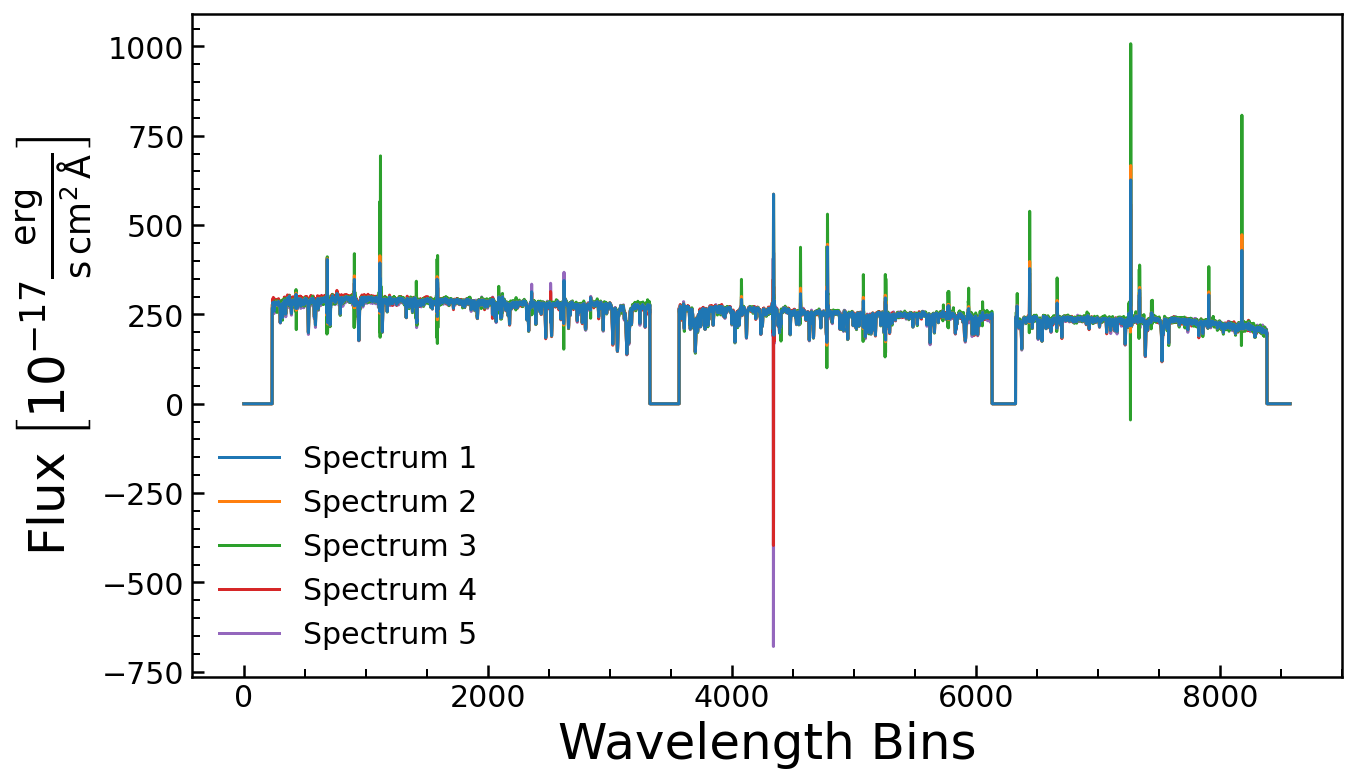

In [503]:
print(f'Number of pixels: {np.shape(data)[1]}')
plt.figure(figsize=(10,6))
for i, spectrum in enumerate(data):
    plt.plot(
        spectrum, 
        label=f'Spectrum {i + 1}',
        zorder=len(data) - i
    )

plt.xlabel('Wavelength Bins')
plt.ylabel(r'Flux $\left[10^{-17} \frac{\rm erg}{{\rm s \, cm^2} \, \AA}\right]$')
# plt.title('M15/2M21275176+1219275')
plt.legend(frameon=False, loc='lower left')
plt.minorticks_on()
plt.tight_layout()
# plt.savefig(
#     figures_dir + 'methods_spectra_example.pdf',
#     format='pdf'
# )
plt.show()

Some spectra has multiple spectrum because of repeated observations. I extract the first spectrum whenever this is the case, since the first spectrum is the combined spectra.
<br>

The wavelengths in the fits files are in log scale, so we need to convert it back to regular wavelengths. CRVAL1 is the center of a pixel and CRDELT1 are the step sizes. The wavelength is computed using
<br>
$$ \lambda = 10^{\rm \, CRVAL1 \, + \, i \, \cdot \, CRDELT1}$$
<br>
where $i$ is the index of a pixel in each spectrum. I referenced this [example](https://live-sdss4org-dr16.pantheonsite.io/irspec/catalogs/).

In [6]:
def get_random_fit_file(file_path):
    """
    Selects a random FITS file from the specified directory.
    
    Parameters:
    - file_path (str): Directory of the FITS file
    
    Returns:
    - random_file_path (str): Directory of the randomly chosen FITS file
    - random_file_name (str): Name of the randomly chosen FITS file
    """
    files = os.listdir(file_path)
    files = [file for file in files if file.endswith('.fits')]
    
    random_file_name = random.choice(files)
    random_file_path = os.path.join(file_path, random_file_name)
    
    return random_file_path, random_file_name

def get_spectrum_data(file_path):
    """
    Parameters:
    - file_path (str): The directory path where the FITS files are located.

    Returns:
    - wavelength (numpy.ndarray): Array of wavelengths corresponding to the spectrum.
    - spectrum (numpy.ndarray): Array of flux values for the spectrum.
    - error (numpy.ndarray): Array of error values for the spectrum.
    - mask (numpy.ndarray): Array of mask values for the spectrum.
    """
    f = fits.open(file_path)
    spectra = f[1].data
    
    # multi-visit
    if len(np.shape(spectra)) > 1:
        spectrum = f[1].data[0]
        errors = f[2].data[0]
        masks = f[3].data[0]
    # individual visit
    else:
        spectrum = f[1].data
        errors = f[2].data
        masks = f[3].data
    
    # reconstruct wavelengths
    CRVAL1 = f[1].header['CRVAL1']    # pixel center
    CRDELT1 = f[1].header['CDELT1']   # pixel step size
    wavelengths = 10**np.arange(CRVAL1, CRVAL1 + len(spectrum)*CRDELT1, CRDELT1)

    return wavelengths, spectrum, errors, masks

def extract_star_field(file_path):
    """
    Parameters:
    - file_path (str): The directory path of the FITS file.

    Returns:
    - star_name (str): The name of the star extracted from the file name.
    - field_name_from_path (str): The name of the field extracted from the directory path.
    """
    # extract file name without extension
    file_name = os.path.splitext(os.path.basename(file_path))[0]
    
    # extract star name
    star_name = file_name.split('-')[2]
    
    # extract field name
    field_name_from_path = os.path.basename(os.path.dirname(file_path))
    
    return star_name, field_name_from_path

*Plot an example spectrum (flux vs. wavelength).*

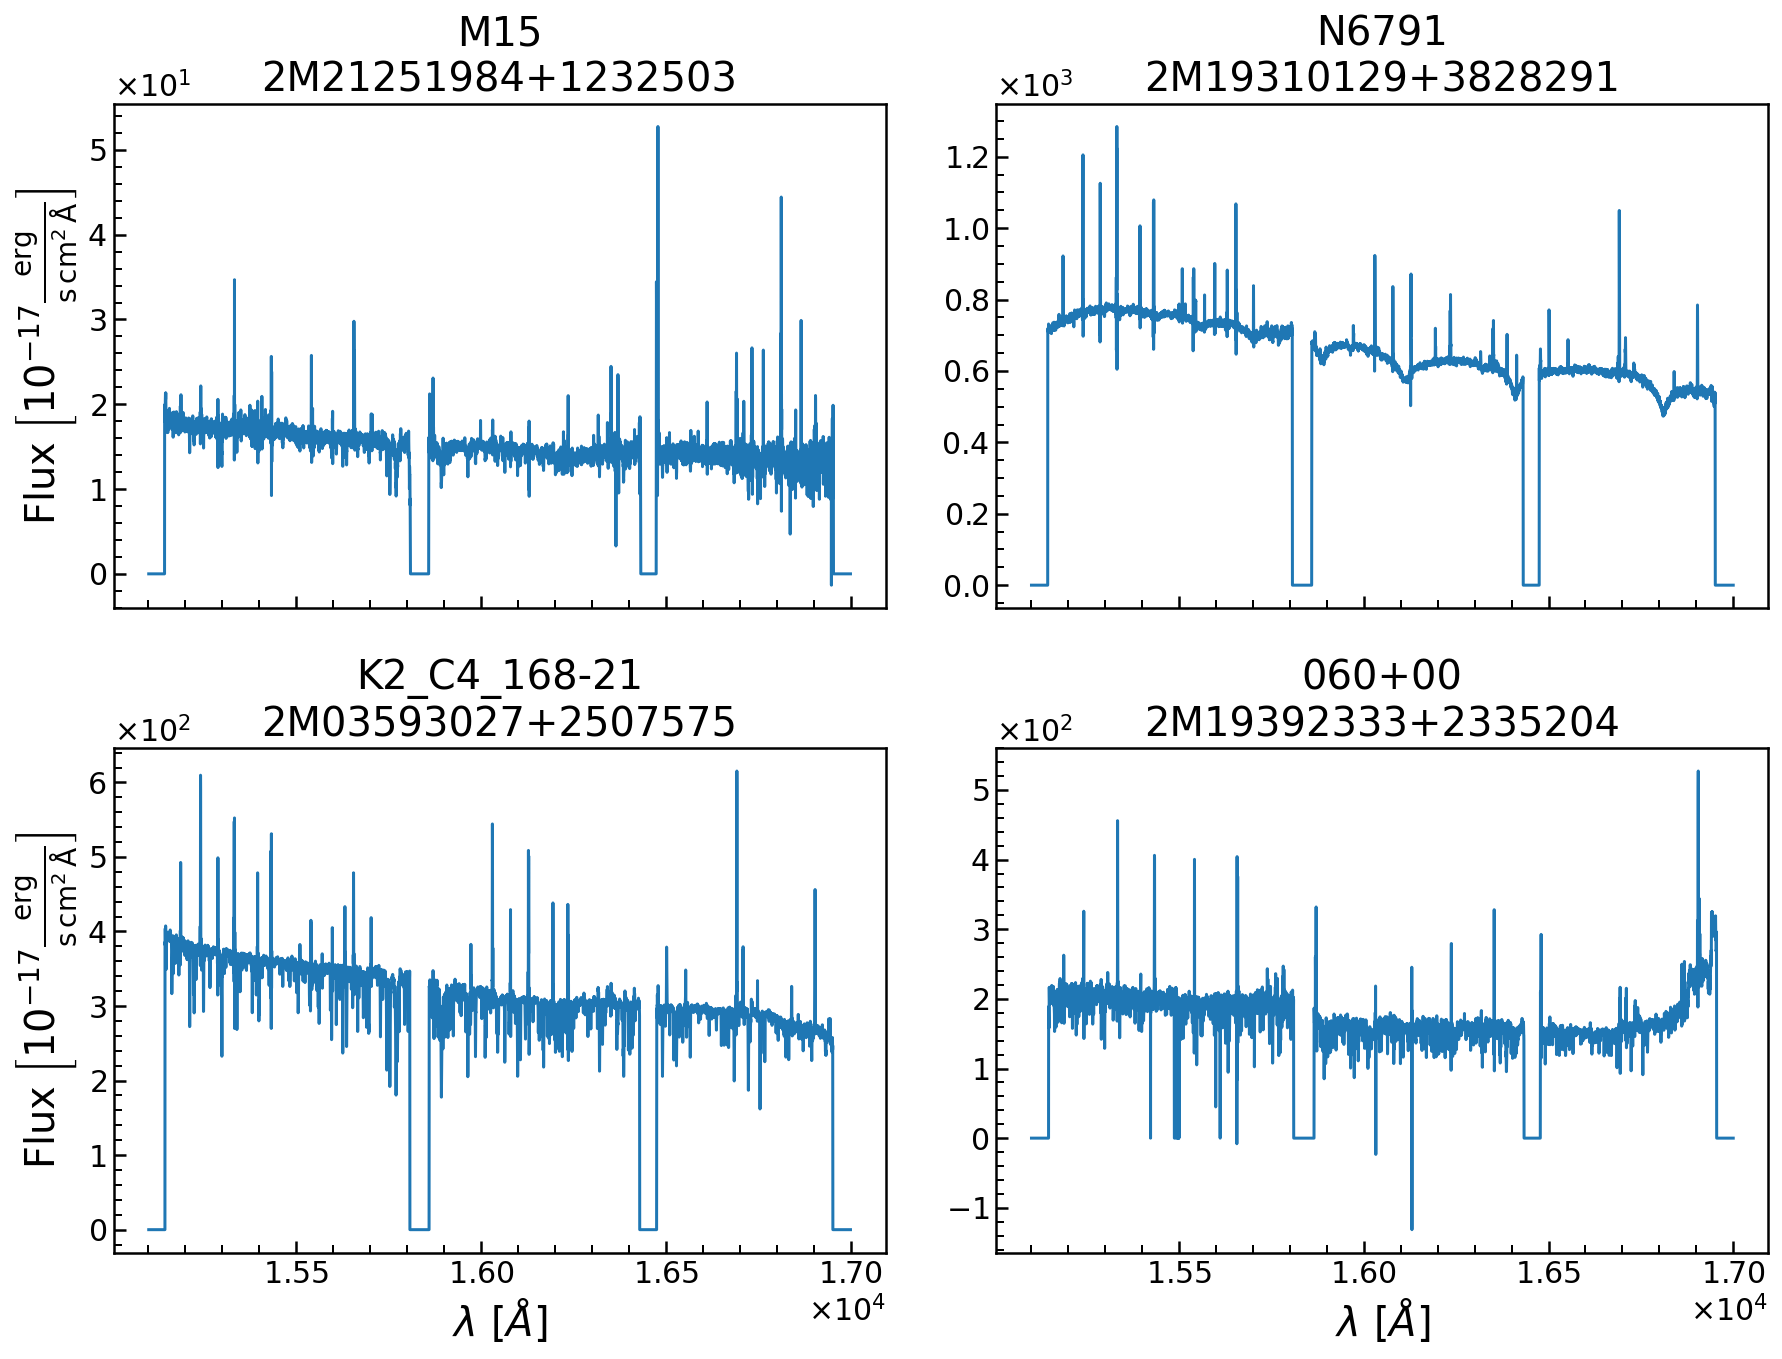

In [504]:
# file paths of chosen fields
file_path_apStar = [
    'data/apStar/M15/',
    'data/apStar/N6791',
    'data/apStar/K2_C4_168-21',
    'data/apStar/060+00'
]

fig, axs = plt.subplots(2, 2, figsize=(13,10), sharex=True)
for i, file_path in enumerate(file_path_apStar):
    # get random file from each field
    random_file_path, random_file_name = get_random_fit_file(file_path)
    
    # get spectra data
    wavelengths, spectrum, errors, masks = get_spectrum_data(random_file_path)
    
    # get star and field names for plotting
    star_name, field_name = extract_star_field(random_file_path)
    
    row = i // 2
    col = i % 2
    
    axs[row, col].plot(
        wavelengths, 
        spectrum, 
        linewidth=1.5,
#         alpha=0.5
    )
    
    axs[row, col].set_title(
        f'{field_name}''\n'f'{star_name}',
        size=20
    )
    if row == 1:
        axs[row, col].set_xlabel(
            r'$\lambda$ $\left[\AA\right]$',
            size=20
        )
    if col == 0:
        axs[row, col].set_ylabel(
            r'Flux $\left[10^{-17} \frac{\rm erg}{{\rm s \, cm^2} \, \AA}\right]$',
            size=20
        )
    axs[row, col].ticklabel_format(
        style='sci',
        axis='both',
        scilimits=(0,0),
        useMathText=True
    )
    
    axs[row, col].minorticks_on()
    
plt.tight_layout()
# plt.savefig(
#     figures_dir + 'methods_apStar_random_spectra.pdf',
#     format='pdf',
# )
plt.show()

# 2. Stellar Properties of Red Giants

*To build a training set, we also need to know the stellar properties ("labels") that have been derived for each spectrum by the ASPCAP pipeline [Garcia-Perez et al. 2015](https://ui.adsabs.harvard.edu/abs/2016AJ....151..144G/abstract). These can be found in the ["allStar" catalog](https://live-sdss4org-dr16.pantheonsite.io/irspec/spectro_data/), and the labels for each spectrum can be found [here](https://data.sdss.org/datamodel/files/APOGEE_ASPCAP/APRED_VERS/ASPCAP_VERS/allStar.html).*

###### Downloading allStar catalog

I downloaded the file $\texttt{allStar-r12-l33.fits}$ directly from [here](https://live-sdss4org-dr16.pantheonsite.io/irspec/spectro_data/). I can also download using $\texttt{rsync_subprocess}$, but that is unnecessary since there is only one file. I found the spectrum labels and their description [here](https://data.sdss.org/datamodel/files/APOGEE_ASPCAP/APRED_VERS/ASPCAP_VERS/allStar.html).

In [305]:
allStar_file_path = 'data/allStar/allStar-r12-l33.fits'

# define columns to be read 
# from FITS file along with 
# their data types
allStar_columns_and_types = {
    'APOGEE_ID': (str,),
    'FILE': (str,),
    'FIELD': (str,),
    'SNR': (np.float32,),
    'TEFF': (np.float32,),
    'TEFF_ERR': (np.float32,),
    'LOGG': (np.float32,),
    'LOGG_ERR': (np.float32,),
    'FE_H': (np.float32,),
    'FE_H_ERR': (np.float32,),
    'MG_FE': (np.float32,),
    'MG_FE_ERR': (np.float32,),
    'SI_FE': (np.float32,),
    'SI_FE_ERR': (np.float32,),
    'ASPCAPFLAG': (np.int32,)
}

allStar_data = fitsio.read(
    allStar_file_path, 
    columns = list(allStar_columns_and_types.keys())
)

allStar_df = pd.DataFrame(allStar_data)

# convert data types of columns
for column, data_type in allStar_columns_and_types.items():
    allStar_df[column] = allStar_df[column].astype(*data_type)
    
print(f'Number of stars: {len(allStar_df)}.')

Number of stars: 473307.


*Due to data quality issues, not all labels have been derived for all stars. Discard all spectra for which:*
* *There are no labels for $T_{\rm eff}$, $\log g$, $\rm [Fe/H]$, $\rm [Mg/Fe]$, $\rm [Si/Fe]$*
* *Low SNR spectra; $\rm SNR < 50$, as reported in the allStar catalog*
* *Dwarf stars ($\log g < 4$, or $T_{\rm eff} < 5,700 K$); the focus of this lab is on giants.*
* *Stars with low metallicity $\rm [Fe/H] < -1$.*

*There should be 1855 stars.*

###### Filtering dataframe

In [306]:
# define list of chosen fields
chosen_fields = ['M15', 'N6791', 'K2_C4_168-21', '060+00']

# slice dataframe for chosen fields
allStar_field_df = allStar_df[allStar_df['FIELD'].isin(chosen_fields)]

# discard spectra without labels for 
# Teff, log g, [Fe/H], [Mg/Fe], [Si/Fe]
labels_to_check = ['TEFF', 'LOGG', 'FE_H', 'MG_FE', 'SI_FE']
for label in labels_to_check:
    allStar_field_df = allStar_field_df[allStar_field_df[label] > -9999]

# discard spectra with low signal-to-noise ratio
allStar_field_df = allStar_field_df[allStar_field_df['SNR'] > 50]

# discard dwarf stars spectra
allStar_field_df = allStar_field_df[allStar_field_df['LOGG'] < 4]
allStar_field_df = allStar_field_df[allStar_field_df['TEFF'] < 5700]

# discard low metallicity spectra
allStar_field_df = allStar_field_df[allStar_field_df['FE_H'] > -1]

# reset the index after filtering
allStar_field_df.reset_index(drop=True, inplace=True)

print(f'Number of stars that fit criteria: {len(allStar_field_df)}.')

Number of stars that fit criteria: 1854.


*Visualize their distribution in label space using a corner plot.*

In [307]:
label_names = [r'$T_{\rm eff}$', r'$\log g$', '[Fe/H]', '[Mg/Fe]', '[Si/Fe]']

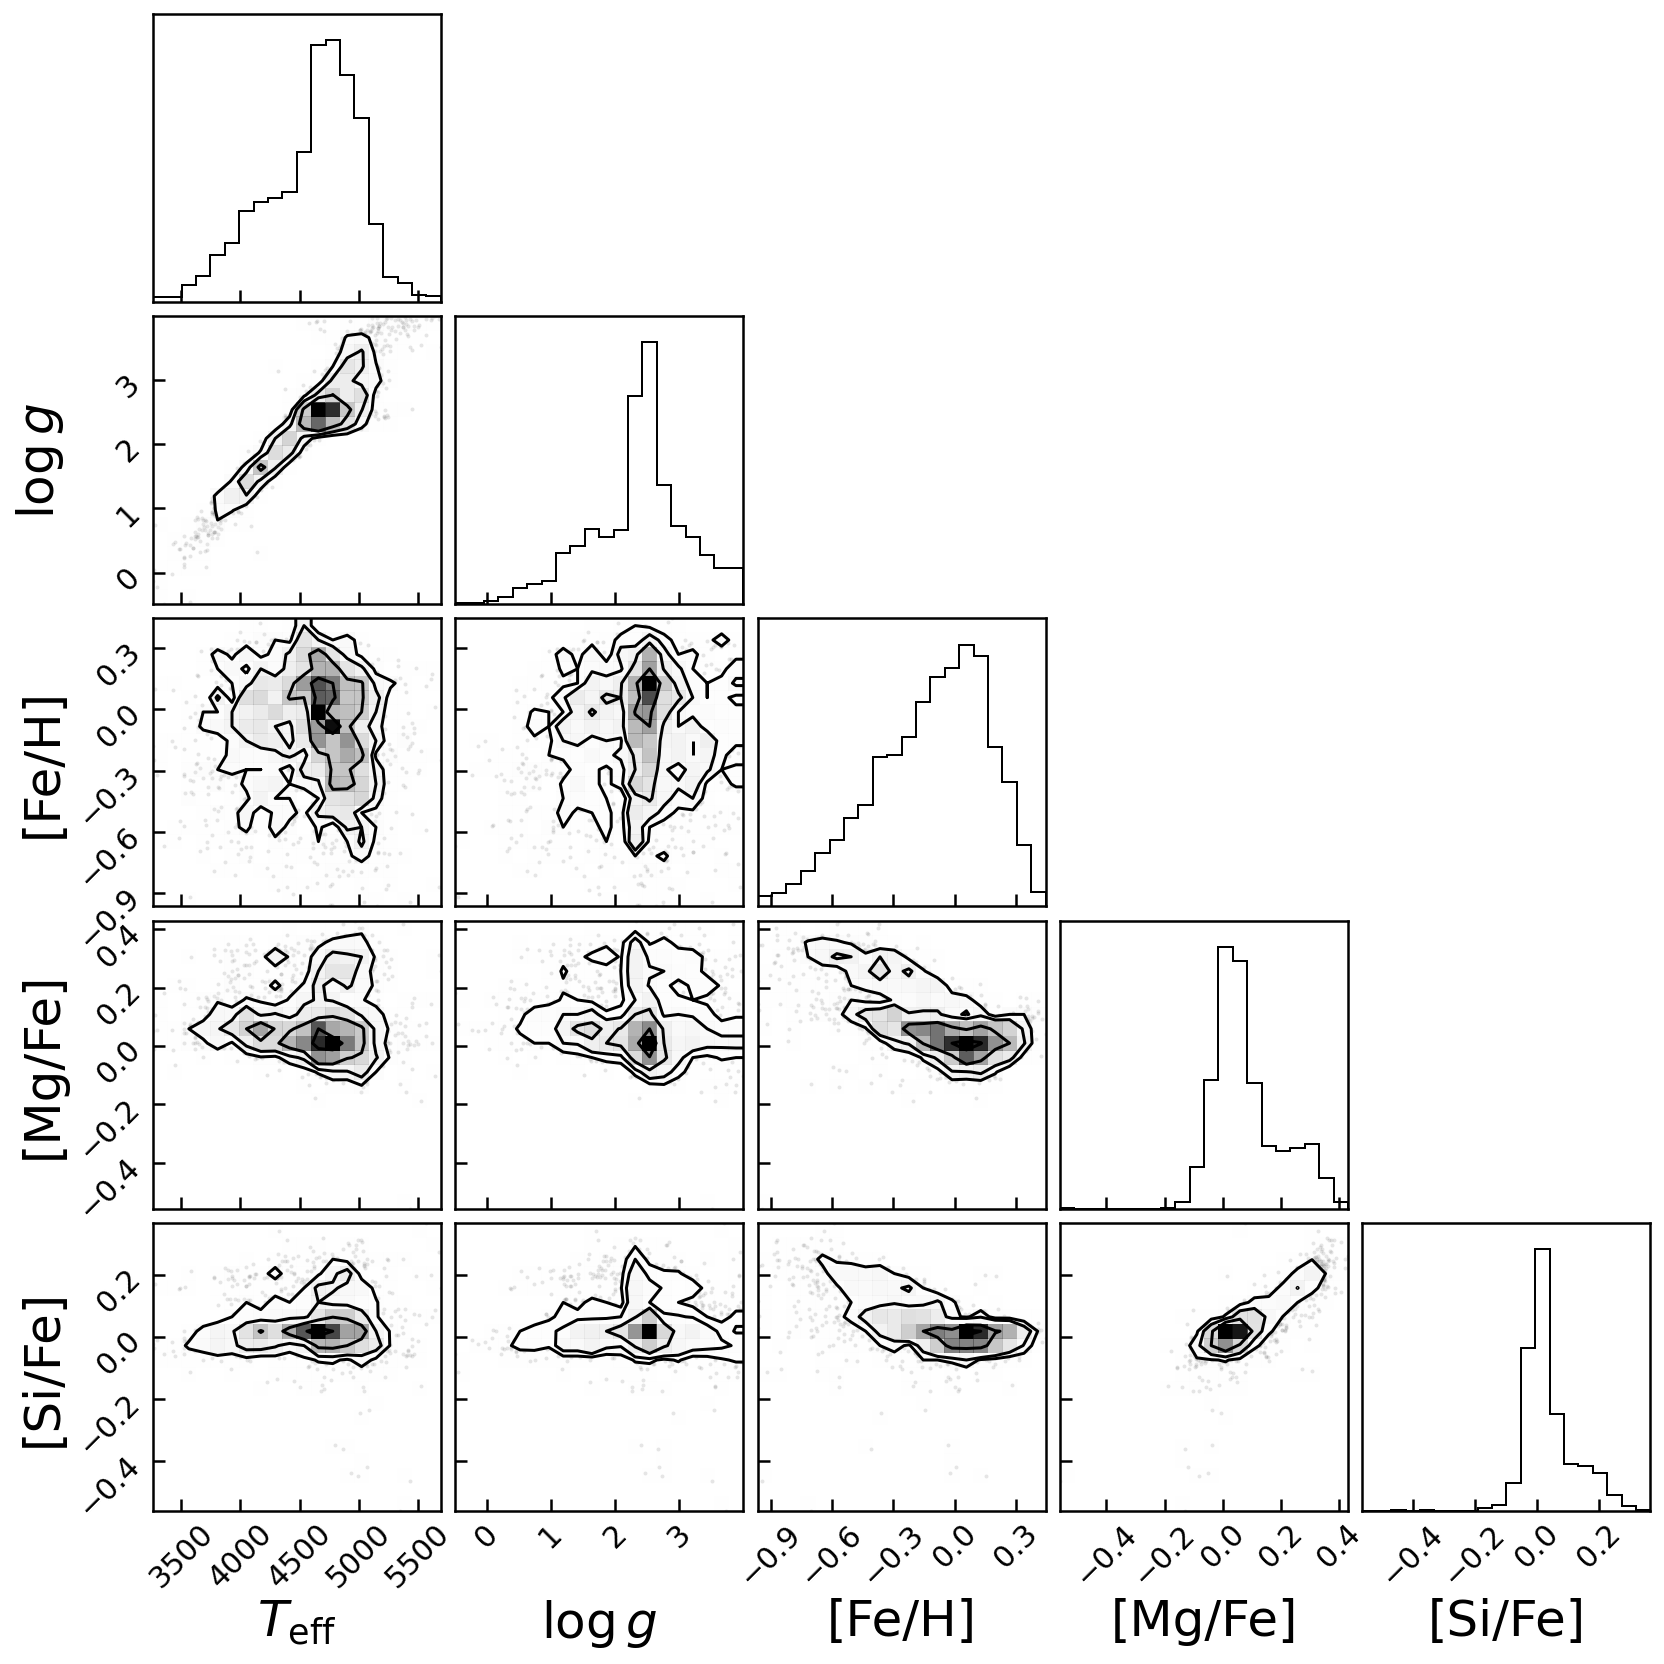

In [321]:
Teff = allStar_field_df['TEFF']
logg = allStar_field_df['LOGG']
FE_H = allStar_field_df['FE_H']
MG_FE = allStar_field_df['MG_FE']
SI_FE = allStar_field_df['SI_FE']

allStar_array = np.vstack(np.transpose([Teff, logg, FE_H, MG_FE, SI_FE]))

figure = corner.corner(
    allStar_array,
    labels = label_names,
#     quantiles=[.16, .5, .84]
)
# plt.savefig(
#     figures_dir + 'results_allStar_labels_corner.pdf',
#     format='pdf',
# )

***Explain how the cut on $\log g$ effectively distinguishes between dwarfs and giants. Consider a solar-mass star, calculate the expected value of $\log g$ on the main sequence (when $R \sim 1 R_{\odot}$), just before the helium flash (when $R \sim 100 R_{\odot}$), and during the core helium burning (when $R \sim 15 R_{\odot}$).***

The surface gravity $g$ of a star is the gravitational acceleration at its surface at the equator. The surface gravity obeys the inverse square law $g \propto R^{-2}$ where $R$ is the radius of a star. For example, consider a solar-mass star. From least to greatest in magnitude, the expected surface gravity on the main sequence (MS), just before the helium flash (HeF), and during the core helium burning (HeB) phase are

$$ g_{\rm HeB} \sim \frac{M_{\odot}}{\left(100 R_{\odot}\right)^2} < g_{\rm HeF} \sim \frac{M_{\odot}}{\left(15 R_{\odot}\right)^2} < g_{\rm MS} \sim \frac{M_{\odot}}{\left(R_{\odot}\right)^2} \,.$$

In log space, that means larger stars, e.g. giants, have smaller $\log \rm g$ values than smaller stars, e.g. dwarfs. So the filter for $\log \rm g < 4$ effectively excludes dwarfs.

# 3. Identifying Bad Pixels with apStar Bitmasks

*Use the apStar bitmasks to identify bad pixels in each spectrum (i.e. pixels where sky subtraction failed, there was a cosmic ray strike, or something else bad happened). Set the uncertainty in these pixels to a large value, so that they will not contribute significantly to the likelihood function in later fitting. The bitmask are a bit unintuitive but are described on in APOGEE data model. To see what each bit means for APOGEE spectra, check the "APOGEE_PIXMASK: APOGEE pixel level mask bits" dropdown menu. Based on experience, bits $0-7$ and $12$ are the most important; the others can probably be ignored.*

I'll do the next two problems for star 2M19395986+2341280, then generalize the code for random spectra later.

In [312]:
# checkpoint 1 star
cp1star_path = 'data/apStar/060+00/apStar-r12-2M19395986+2341280.fits'

cp1_wvl, cp1_spc, cp1_err, cp1_msk = get_spectrum_data(cp1star_path)
cp1_star_name, cp1_field_name = extract_star_field(cp1star_path)

###### Inspecting errors

In [15]:
with fits.open(cp1star_path, memmap=True) as hdul:
    info = hdul[1].header
    spectra = hdul[1].data
    errors = hdul[2].data
    masks = hdul[3].data

In [16]:
hdul[3].header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                   16 / Number of bits per data pixel                  
NAXIS   =                    2 / Number of data axes                            
NAXIS1  =                 8575 /                                                
NAXIS2  =                    5 /                                                
PCOUNT  =                    0 / No Group Parameters                            
GCOUNT  =                    1 / One Data Group                                 
CRVAL1  =        4.17900000000 /                                                
CDELT1  =    6.00000000000E-06 /                                                
CRPIX1  =                    1 /                                                
CTYPE1  = 'LOG-LINEAR'         /                                                
DC-FLAG =                    1 /                                                
BUNIT   = 'Flag Mask (bitwis

###### Inspecting masks

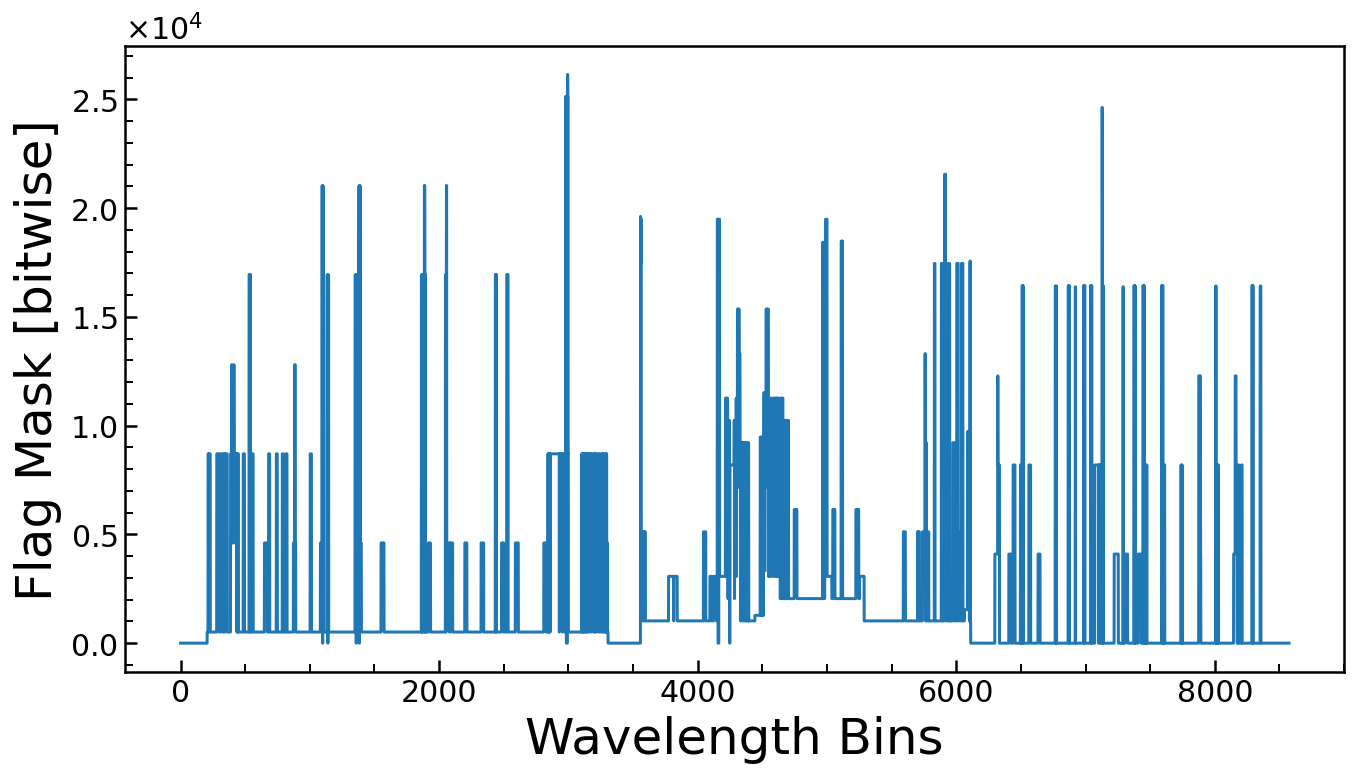

In [505]:
plt.figure(figsize=(10,6))
plt.plot(cp1_msk)
plt.xlabel('Wavelength Bins')
plt.ylabel('Flag Mask [bitwise]')
# plt.title(f'Spectra Flag Masks\n{cp1_field_name}/{cp1_star_name}')
plt.ticklabel_format(
        style='sci',
        axis='y',
        scilimits=(0,0),
        useMathText=True
)
plt.minorticks_on()
plt.tight_layout()
# plt.savefig(
#     figures_dir + 'methods_cp1star_flag_masks.pdf',
#     format='pdf'
# )
plt.show()

In [16]:
cp1_unique_masks = np.unique(cp1_msk)
print(cp1_unique_masks)

[    0     1   512  1024  1280  1536  2048  3072  3328  4096  4608  5120
  6144  7168  8192  8704  8720  9216  9472  9728 10240 11264 11520 12288
 12800 13312 15360 16386 16417 16433 16435 16929 16931 16945 17441 17457
 17569 17953 18434 18481 19489 19617 21025 21027 21041 21553 24625 25121
 25137 26145]


###### Converting mask integers to binary representations

In [17]:
# convert integer to binary string
def integer_to_binary(integer):
    binary = bin(integer)[2:]
    return binary

In [19]:
cp1_msk_bin = [integer_to_binary(value) for value in cp1_unique_masks]

print('Flag masks for which bits 0-7, and/or 12, are set to true:')

for index, integer in enumerate(cp1_unique_masks):
    # reverse the binary string
    # so index 0 is bit 0
    cp1_msk_bin_rvrs = cp1_msk_bin[index][::-1]
    # separate case for mask integer
    # with bit string longer than 1
    if len(cp1_msk_bin_rvrs)>1:
        # filter for bits 0-7 and 12
        cp1_bin_filtered = cp1_msk_bin_rvrs[0:8] + cp1_msk_bin_rvrs[12:13]
        # check if a bit is set to TRUE
        if '1' in cp1_bin_filtered:
            print(f'{integer}: {cp1_msk_bin_rvrs}')
            print(f'binary digits: {len(cp1_msk_bin_rvrs)}')
    else:
        # case of bit string length 1
        if '1' in cp1_msk_bin_rvrs:
            print(f'{integer}: {cp1_msk_bin_rvrs}')
            print(f'binary digits: {len(cp1_msk_bin_rvrs)}')

Flag masks for which bits 0-7, and/or 12, are set to true:
1: 1
binary digits: 1
4096: 0000000000001
binary digits: 13
4608: 0000000001001
binary digits: 13
5120: 0000000000101
binary digits: 13
6144: 0000000000011
binary digits: 13
7168: 0000000000111
binary digits: 13
8720: 00001000010001
binary digits: 14
12288: 00000000000011
binary digits: 14
12800: 00000000010011
binary digits: 14
13312: 00000000001011
binary digits: 14
15360: 00000000001111
binary digits: 14
16386: 010000000000001
binary digits: 15
16417: 100001000000001
binary digits: 15
16433: 100011000000001
binary digits: 15
16435: 110011000000001
binary digits: 15
16929: 100001000100001
binary digits: 15
16931: 110001000100001
binary digits: 15
16945: 100011000100001
binary digits: 15
17441: 100001000010001
binary digits: 15
17457: 100011000010001
binary digits: 15
17569: 100001010010001
binary digits: 15
17953: 100001000110001
binary digits: 15
18434: 010000000001001
binary digits: 15
18481: 100011000001001
binary digits: 

If bitmasks for bits 0-7 and 12 are not zero, then define new errors.

In [20]:
# inflate errors
def set_pixel_uncertainty(errors, masks):
    """
    Set pixel uncertainties to a large value for flagged pixels in the spectrum.

    Parameters:
    - errors (numpy.ndarray): Array of error values for each pixel in the spectrum.
    - masks (numpy.ndarray): Array of mask values indicating flags for each pixel.

    Returns:
    - errors_inflated (numpy.ndarray): Array of error values with inflated uncertainties.
    """
    # initialize new errors
    inflated_errors = errors.copy()
    
    # convert mask integers to binary
    masks_binary = [integer_to_binary(n) for n in masks]
    
    for index, mask in enumerate(masks_binary):
        # reverse index to start with 2^0
        mask_binary_reversed = masks_binary[index][::-1]
        # bit string longer than 1 digit
        if len(mask_binary_reversed) > 1:
            # filter for bits 0-7, 12
            mask_binary_filtered = mask_binary_reversed[0:8] + mask_binary_reversed[12:13]
            # bit(s) set to true (bad)
            if '1' in mask_binary_filtered:
                inflated_errors[index] = 1e10    # inflate error
        # bit string is 1 digit
        else:
            # bit set to true (bad)
            if '1' in mask_binary_reversed:
                inflated_errors[index] = 1e10    # inflate error
    
    return inflated_errors

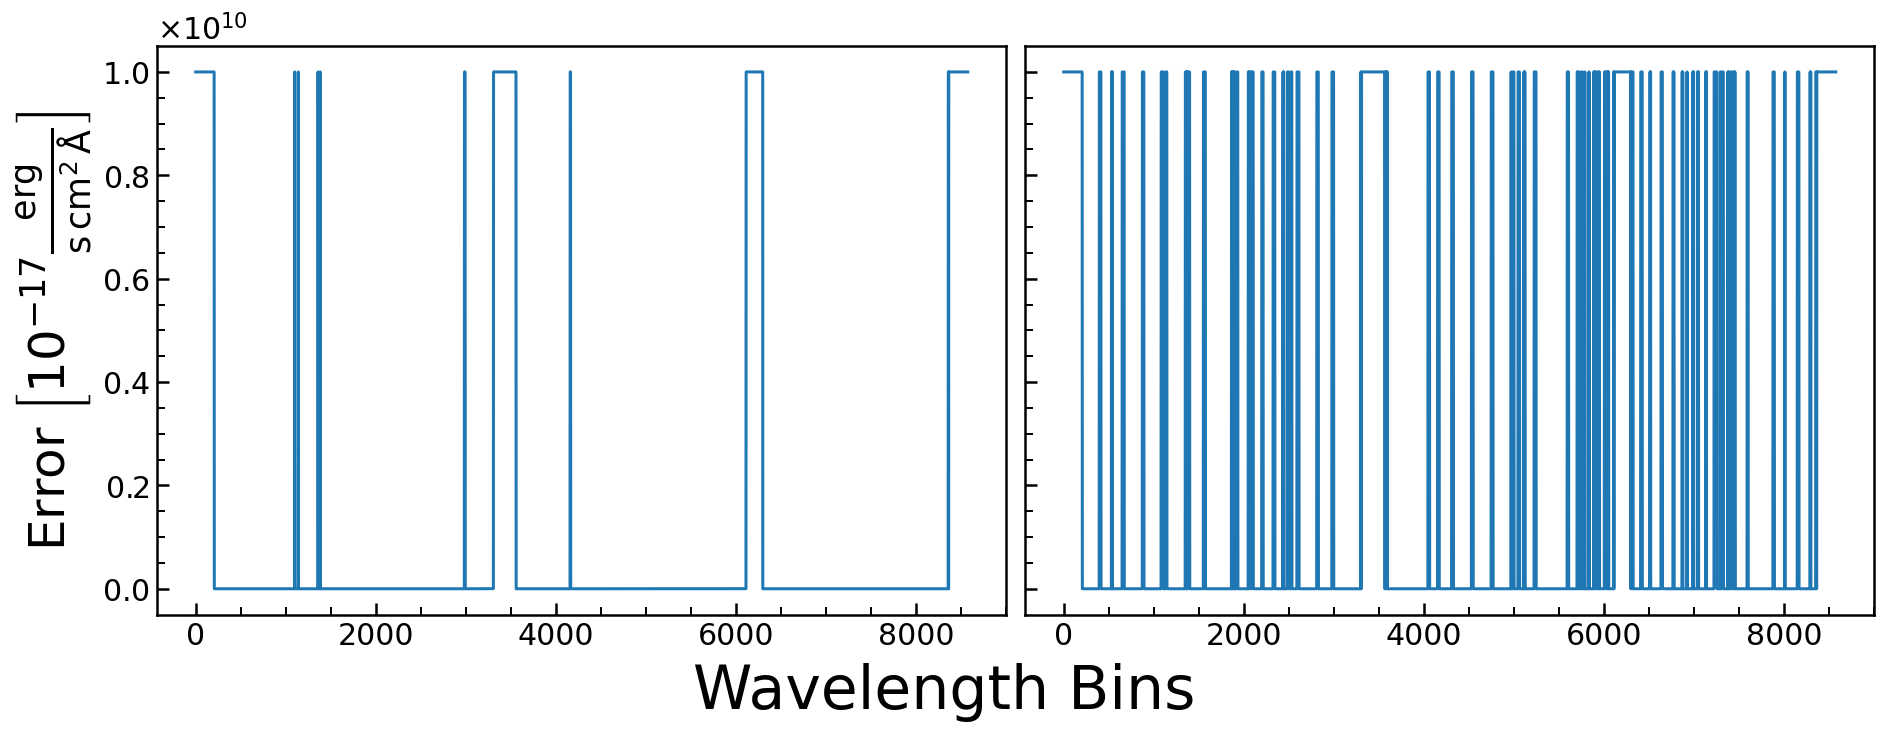

In [506]:
cp1_err_inflated = set_pixel_uncertainty(cp1_err, cp1_msk)

fig, axs = plt.subplots(1,2, figsize=(13,5), sharey=True, layout='constrained')
fig.supxlabel('Wavelength Bins')
# fig.suptitle(f'{cp1_field_name}/{cp1_star_name}')

axs[0].plot(cp1_err, linewidth=1.5)
# axs[0].set_title('Raw Errors')
axs[0].set_ylabel(
    r'Error $\left[10^{-17} \frac{\rm erg}{{\rm s \, cm^2} \, \AA}\right]$'
)
axs[0].minorticks_on()
axs[0].ticklabel_format(
    style='sci',
    axis='y',
    scilimits=(0,0),
    useMathText=True
)

axs[1].plot(cp1_err_inflated, linewidth=1.5)
# axs[1].set_title('Inflated Errors')
axs[1].minorticks_on()
axs[1].ticklabel_format(
    style='sci',
    axis='y',
    scilimits=(0,0),
    useMathText=True
)
# plt.savefig(
#     figures_dir + 'methods_bad_pixel_errors.pdf',
#     format='pdf'
# )
plt.show()

Count the number of bad pixels

In [38]:
# initialize counters for bad pixels with large errors
num_pixels_new_err = 0 # number of bad pixels with new errors
num_pixels_old_err = 0 # number of bad pixels from old errors

# count pixels with modified and original uncertainties
for i in range(len(cp1_err)):
    if cp1_err_inflated[i] == 1.0e10:
        num_pixels_new_err += 1
    if cp1_err[i] == 1.0e10:
        num_pixels_old_err += 1

print(f'Number of bad pixels with new errors: {num_pixels_new_err}.')
print(f'Number of bad pixels from old errors: {num_pixels_old_err}.')
print(f'Total number of pixels: {len(cp1_err)}.')

Number of bad pixels with new errors: 1840.
Number of bad pixels from old errors: 884.
Total number of pixels: 8575.


# 4.

*Before we fit spectra, we need to "pseudo-continuum normalize" them, as described in [Ness et al. 2015](https://ui.adsabs.harvard.edu/abs/2015ApJ...808...16N/abstract).* ***Explain what this means and why it is useful. What is the difference between pseudo-continuum normalization and "true" continuum normalization?***
<br>

*Developing a continuum normalization procedure from scratch is challenging: an iterative method is required to determine which wavelengths are insensitive to label changes, and thus good for fitting continuum). To find out more about this, read sections 2.3 and 5.3 of [Ness et al. 2015](https://ui.adsabs.harvard.edu/abs/2015ApJ...808...16N/abstract).*
<br>

*In this lab, we are making the problem a bit easier by providing you with a list of wavelengths $\texttt{continuum_pixels_apogee.npz}$ that do not contain any strong absorption lines. In other words, the flux value at these wavelengths should not depend much on the spectral labels of the star, but only on its absolute magnitude and distance. ***Write a function that uses the flux in these wavelength pixels to estimate the continuum over the full APOGEE wavelength range.*** Section 2.3 of [Ness et al. 2015](https://ui.adsabs.harvard.edu/abs/2015ApJ...808...16N/abstract) should be useful. Because the APOGEE spectra are split over three chips, with gaps between the chips, your continuum-determination procedure will probably work better if you handle the three chips individually.*
<br>

*Normalize all your spectra and error arrays.* ***Plot some example un-normalized spectrum, the derived pseudo-continuum, and the normalized spectrum.***

###### Defining wavelength ranges (chips) and trusted indices

I use the wavelengths from the provided $\texttt{continuum_pixels_apogee.npz}$ file to clean the spectra. 

In [39]:
# fine apogee wavelength grid
apogee_grid = np.load('data/apogee_wavelength.npz')
apogee_wvl = apogee_grid['wavelength']

# use provided cannon wavelengths as trusted values
cannon_data = np.load('data/cannon_continuum_apogee.npz')
cannon_wavelengths = cannon_data['wavelengths']
cannon_indices = cannon_data['trusted']

Remove bad pixels using method from problem 3, using trusted wavelengths given by Cannon-derived continuum (section 5.3 of Ness et al.)

In [40]:
def interpolate_spectrum(file_path):
    """
    Interpolate spectrum data onto provided fine wavelength grid
    """
    wavelengths, spectrum, errors, masks = get_spectrum_data(file_path)
    inflated_errors = set_pixel_uncertainty(errors, masks)
    
    # interpolate onto finer grid
    fine_spectrum = np.interp(
        apogee_wvl,
        wavelengths,
        spectrum
    )
    fine_errors = np.interp(
        apogee_wvl,
        wavelengths,
        inflated_errors
    )
    
    return fine_spectrum, fine_errors

In [41]:
def get_trusted_spectrum(file_path):
    fine_spectrum, fine_errors = interpolate_spectrum(file_path)
    
    trusted_spectrum = fine_spectrum[cannon_indices]
    trusted_errors = fine_errors[cannon_indices]
    
    return trusted_spectrum, trusted_errors

Split the data into three separate wavelength chips

In [42]:
# define apogee wavelength chips
apogee_chips = [
    (15150, 15800),
    (15890, 16430),
    (16490, 16950)
]

In [43]:
def split_chips(wavelengths, spectrum, errors, chip_ranges):

    chip_wavelengths_list = []
    chip_spectrum_list = []
    chip_errors_list = []
    
    for chip_index, (start, end) in enumerate(chip_ranges):
        start_index = np.searchsorted(wavelengths, start)
#         print(f'Start wavelength and index for chip {chip_index + 1}: {start} at {start_index}.')
        end_index = np.searchsorted(wavelengths, end)
#         print(f'End wavelength and index for chip {chip_index + 1}: {end} at {end_index}.')
        
        wvl_chip = wavelengths[start_index:end_index]
        spc_chip = spectrum[start_index:end_index]
        err_chip = errors[start_index:end_index]
        
        chip_wavelengths_list.append(wvl_chip)
        chip_spectrum_list.append(spc_chip)
        chip_errors_list.append(err_chip)

    chip_wavelengths = np.concatenate(chip_wavelengths_list)
    chip_spectrum = np.concatenate(chip_spectrum_list)
    chip_errors = np.concatenate(chip_errors_list)
    
    return chip_wavelengths, chip_spectrum, chip_errors

###### Plotting unnormalized spectrum of star 2M19395986+2341280

In [338]:
def plot_clean_unnormalized_spectrum(file_path, chip_ranges):    
    fine_spectrum, fine_errors = interpolate_spectrum(file_path)
    
    chip_wavelengths, chip_spectrum, chip_errors = split_chips(
        apogee_wvl, fine_spectrum, fine_errors, apogee_chips
    )
    
    star_name, field_name = extract_star_field(file_path)
    
    for chip_index, (start, end) in enumerate(chip_ranges):
        start_index = np.searchsorted(chip_wavelengths, start)
        end_index = np.searchsorted(chip_wavelengths, end)
        
        plt.plot(
            chip_wavelengths[start_index:end_index],
            chip_spectrum[start_index:end_index],
            linewidth=1.5,
            alpha=0.5,
            zorder=1
        )
    
#     plt.xlabel(r'$\lambda$ $\left[\rm \AA\right]$')
    plt.ylabel(r'Flux $\left[10^{-17} \frac{\rm erg}{{\rm s \, cm^2} \, \AA}\right]$')
#     plt.title(f'Unnormalized Spectrum \n {field_name}/{star_name}')
    plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0), useMathText=True)

###### Constructing pseudo-continuum

In [57]:
def get_pseudo_continuum(file_path, chip_ranges, poly_order):
    
    fine_spectrum, fine_errors = interpolate_spectrum(file_path)

    trusted_spectrum, trusted_errors = get_trusted_spectrum(file_path)
    
    chip_wavelengths, chip_spectrum, chip_errors = split_chips(
        apogee_wvl, fine_spectrum, fine_errors, apogee_chips
    )

    coefficients_list = []
    continuum_wvl_list = []
    pseudo_continuum_list = []
    
    for i, (start, end) in enumerate(chip_ranges):
        # divide cannon continuum into chips
        cannon_start_idx = np.searchsorted(cannon_wavelengths[cannon_indices], start)
        cannon_end_idx = np.searchsorted(cannon_wavelengths[cannon_indices], end)
        
        # divide spectrum into chips
        start_idx = np.searchsorted(chip_wavelengths, start)
        end_idx = np.searchsorted(chip_wavelengths, end)
        
        # get pseudo-continuum coefficients
        # from provided cannon continuum
        coeffs = chebfit(
            cannon_wavelengths[cannon_indices][cannon_start_idx:cannon_end_idx],
            trusted_spectrum[cannon_start_idx:cannon_end_idx],
            deg=poly_order,
            w=1/trusted_errors[cannon_start_idx:cannon_end_idx]
        )
        
        x_values = np.linspace(
            chip_wavelengths[start_idx],
            chip_wavelengths[end_idx-1],
            num=end_idx - start_idx
        )

        # compute pseudo-continuum
        y_values = chebval(x_values, coeffs)
        
        coefficients_list.append(coeffs)
        continuum_wvl_list.extend(x_values)
        pseudo_continuum_list.extend(y_values)
    
    coefficients = np.array(coefficients_list)
    continuum_wavelengths = np.array(continuum_wvl_list)
    pseudo_continuum = np.array(pseudo_continuum_list)

    return continuum_wavelengths, pseudo_continuum, coefficients

###### Plot pseudo-continuum

In [339]:
def plot_pseudo_continuum(file_path, chip_ranges, poly_order):
    star_name, field_name = extract_star_field(file_path)
    
    fine_spectrum, fine_errors = interpolate_spectrum(file_path)
    
    chip_wavelengths, chip_spectrum, chip_errors = split_chips(
        apogee_wvl, fine_spectrum, fine_errors, apogee_chips
    )
    
    continuum_wavelengths, pseudo_continuum, coefficients = get_pseudo_continuum(
        file_path, chip_ranges, poly_order
    )
    
#     for i, (start, end) in enumerate(chip_ranges):
#         start_idx = np.searchsorted(chip_wavelengths, start)
#         end_idx = np.searchsorted(chip_wavelengths, end)

#         plt.plot(
#             continuum_wavelengths[start_idx:end_idx],
#             pseudo_continuum[start_idx:end_idx],
#             linewidth=1.5,
#             label = f"continuum {i+1}:\n{', '.join('{:.2e}'.format(coeff) for coeff in coefficients[i])}"
#         )
    plt.plot(
        continuum_wavelengths,
        pseudo_continuum,
        linewidth=1.5
    )
    
#     plt.title(f'Pseudo-Continuum Fit\n{field_name}/{star_name}')
#     plt.xlabel(r'$\lambda$ $\left[\rm \AA\right]$')
    plt.ylabel(r'Flux $\left[10^{-17} \frac{\rm erg}{{\rm s \, cm^2} \, \AA}\right]$')
    plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0), useMathText=True)

###### Pseudo-continuum normalize

In [510]:
def pseudo_continuum_normalize(file_path, chip_ranges, poly_order):
    fine_spectrum, fine_errors = interpolate_spectrum(file_path)
    
    chip_wavelengths, chip_spectrum, chip_errors = split_chips(
        apogee_wvl, fine_spectrum, fine_errors, apogee_chips
    )
    
    continuum_wavelengths, pseudo_continuum, coefficients = get_pseudo_continuum(
        file_path, chip_ranges, poly_order
    )
    
    pseudo_norm_spectra_list = []
    pseudo_norm_errors_list = []
    
    for i, (start, end) in enumerate(chip_ranges):
        start_index = np.searchsorted(chip_wavelengths, start)
        end_index = np.searchsorted(chip_wavelengths, end)
        
        # normalize with derived pseudo-continuum
        pseudo_norm_spectra = chip_spectrum[start_index:end_index]/pseudo_continuum[start_index:end_index]
        pseudo_norm_errors = chip_errors[start_index:end_index]/pseudo_continuum[start_index:end_index]
        
        pseudo_norm_spectra_list.extend(pseudo_norm_spectra.tolist())
        pseudo_norm_errors_list.extend(pseudo_norm_errors.tolist())
    
    pseudo_norm_spectra = np.array(pseudo_norm_spectra_list)
    pseudo_norm_errors = np.array(pseudo_norm_errors_list)
    
    return continuum_wavelengths, pseudo_norm_spectra, pseudo_norm_errors

In [511]:
def plot_pseudo_norm_spectrum(file_path, chip_ranges, poly_order):
    star_name, field_name = extract_star_field(file_path)
    
    continuum_wavelengths, pseudo_norm_spectra, pseudo_norm_errors = pseudo_continuum_normalize(
        file_path, chip_ranges, poly_order
    )

    plt.axhline(1, linestyle='--', c='black')
    
    for i, (start, end) in enumerate(chip_ranges):
        start_index = np.searchsorted(continuum_wavelengths, start)
        end_index = np.searchsorted(continuum_wavelengths, end)
        
        plt.plot(
            continuum_wavelengths[start_index:end_index],
            pseudo_norm_spectra[start_index:end_index],
            alpha=0.5,
        )
        
#     plt.plot(
#         continuum_wavelengths,
#         pseudo_norm_spectra,
#         alpha=0.5,
#         label=f'pseudo-normalized'
#     )
    
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
#     plt.title(f'Pseudo-continuum Normalized Spectrum\n{field_name}/{star_name}')
    plt.xlabel(r'$\lambda$ $\left[\rm \AA\right]$')
    plt.ylabel('Normalized')

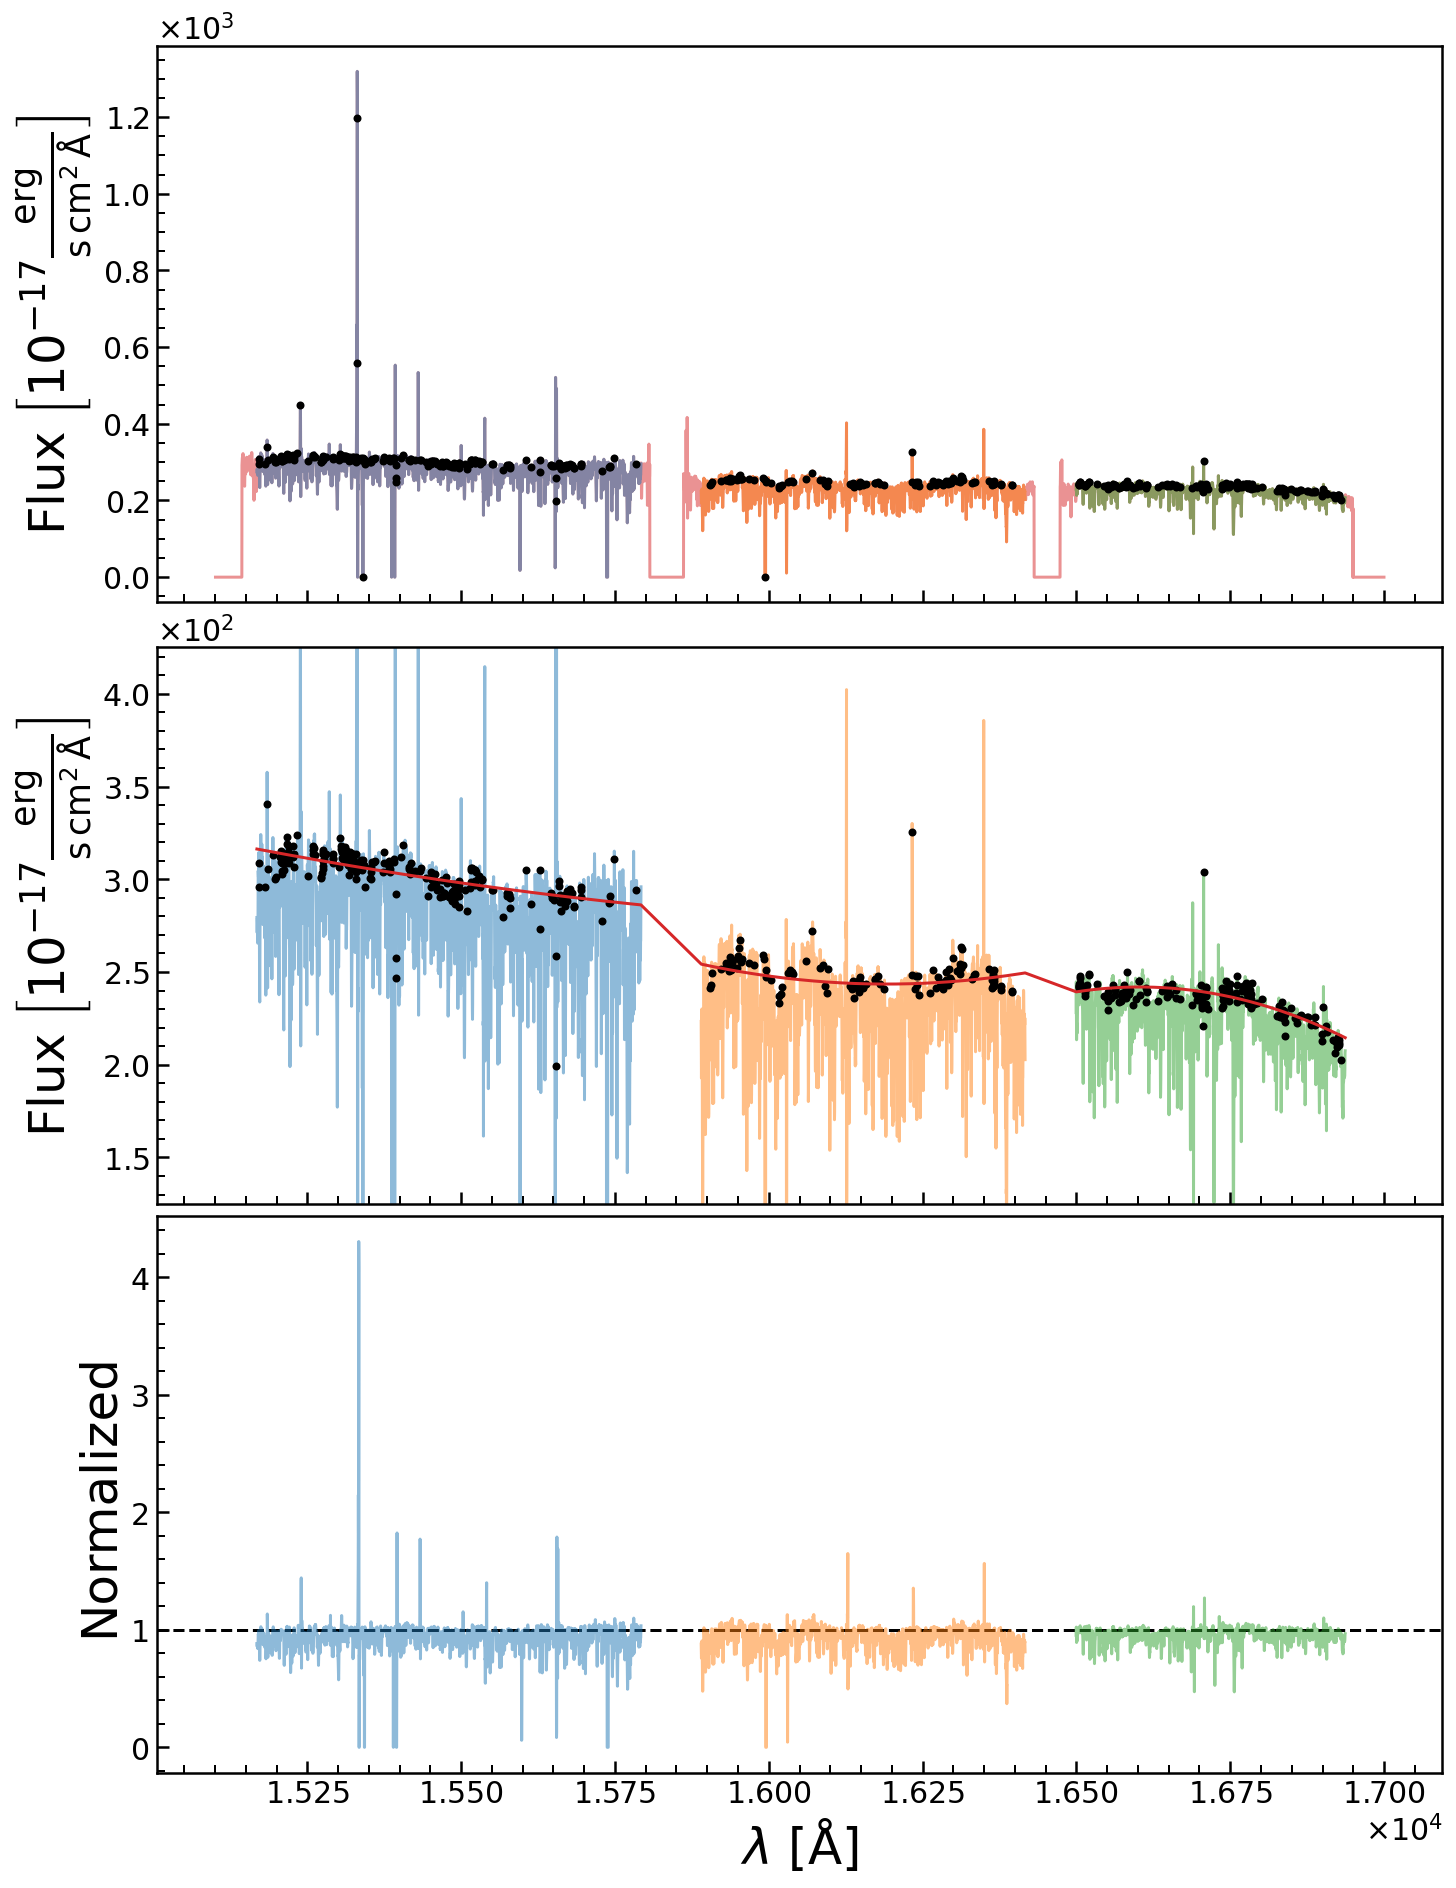

In [512]:
# Create a common figure
fig, axs = plt.subplots(3, 1, figsize=(10, 13), sharex=True, layout='constrained')

# Plot 1
plt.sca(axs[0])
plot_clean_unnormalized_spectrum(cp1star_path, apogee_chips)
plt.plot(cp1_wvl, cp1_spc, alpha=0.5, zorder=0)
plt.scatter(cannon_wavelengths[cannon_indices], cp1_spc_trusted, marker='.', c='black', zorder=2)
plt.minorticks_on()
# plt.ylim(125, 425)
# plt.title('Unnormalized Spectrum')

plt.sca(axs[1])
plot_clean_unnormalized_spectrum(cp1star_path, apogee_chips)
plt.scatter(cannon_wavelengths[cannon_indices], cp1_spc_trusted, marker='.', c='black')
plot_pseudo_continuum(cp1star_path, apogee_chips, poly_order=2)
plt.minorticks_on()
plt.ylim(125, 425)
# plt.title('Chebyshev Pseudo-Continuum Fit')

plt.sca(axs[2])
plot_pseudo_norm_spectrum(cp1star_path, apogee_chips, poly_order=2)
plt.minorticks_on()
# plt.ylim(0.5, 1.5)
# plt.title('Pseudo-Continuum Normalized Spectrum')

# plt.savefig(
#     figures_dir + 'results_cp1star_spectrum.pdf',
#     format='pdf'
# )

plt.show()

# 5. Training and cross-validation sets

*Divide the cleaned spectra into randomly selected groups of roughly equal size. Designate one group the training set and the other the cross-validation set.*

First, I extract $\texttt{apStar}$ file names and field names from the $\texttt{allStar}$ catalog. These stars have known stellar properties, or labels, derived from the $\texttt{APOGEE/ASPCAP}$ pipeline.

In [175]:
allStar_file_names_list = []

allStar_file_names = np.array(allStar_field_df['FILE'])
allStar_field_names = np.array(allStar_field_df['FIELD'])

for i in range(len(allStar_file_names)):
    allStar_file_name = allStar_field_names[i] + '/' + allStar_file_names[i]
    allStar_file_names_list.append(allStar_file_name)

I use file name list from the $\texttt{allStar}$ catalog to normalize all cross-matched spectrum from the $\texttt{apStar}$ files downloaded in problem 1, using the functions developed in problems 3 and 4. 

In [176]:
# split into equal size training and testing data sets
file_list_train, file_list_test, label_list_train, label_list_test = train_test_split(
    allStar_file_names_list, allStar_field_df, train_size = 0.5, random_state = 42
)

# normalize training and testing data sets
wavelengths_list_train = []
spectra_list_train = []
errors_list_train = []

wavelengths_list_test = []
spectra_list_test = []
errors_list_test = []

for i_idx, file_name in enumerate(file_list_train):
#     print(f'Training set {i_idx + 1}')
    
    # normalize training set
    wvl_train, spc_train, err_train = pseudo_continuum_normalize(
        'data/apStar/' + file_name,
        apogee_chips,
        poly_order=2
    )
    
    wavelengths_list_train.append(wvl_train)
    spectra_list_train.append(spc_train)
    errors_list_train.append(err_train)

for j_idx, file_name in enumerate(file_list_test):
#     print(f'Testing set {j_idx + 1}')
    
    # normalize testing set
    wvl_test, spc_test, err_test = pseudo_continuum_normalize(
        'data/apStar/' + file_name,
        apogee_chips,
        poly_order=2
    )
    
    wavelengths_list_test.append(wvl_test)
    spectra_list_test.append(spc_test)
    errors_list_test.append(err_test)

wavelengths_train = np.array(wavelengths_list_train)
spectra_train = np.array(spectra_list_train)
errors_train = np.array(errors_list_train)

wavelengths_test = np.array(wavelengths_list_test)
spectra_test = np.array(spectra_list_test)
errors_test = np.array(errors_list_test)

In [84]:
# check dimensions of training and testing sets
print(np.shape(wavelengths_train))
print(np.shape(spectra_train))
print(np.shape(errors_train))

print(np.shape(wavelengths_test))
print(np.shape(spectra_test))
print(np.shape(errors_test))

(927, 7174)
(927, 7174)
(927, 7174)
(927, 7174)
(927, 7174)
(927, 7174)


# 6. Spectral Model

*Use the training set to build a spectral model that predicts the spextrum at ***at each wavelength pixel*** as a function of the 5 labels: $T_{\rm eff}$, $\log g$, $\left[\rm Fe/H \right]$, $\left[\rm Mg/Fe \right]$, $\left[\rm Si/Fe \right]$. Following [Ness et al.](https://ui.adsabs.harvard.edu/abs/2015ApJ...808...16N/abstract), make the spectral model a 2nd-order polynomial in labels. The final spectral model will consist of thousands of individual models - one for each wavelength pixel - stitched together. In addition to the model free parameters, fit an intrinsic scatter term, $s_{\lambda}^2$, at each wavelength. The intrinsic scatter is defined such that the variance in the observed normalized flux values at wavelength $\lambda$ is given by $s_{\lambda}^2 + \sigma_{\lambda}^2$, where $\sigma_{\lambda}$ is the uncertainty in the normalized flux.*

### 6. a) Linear equation

*Consider a single pixel of wavelength $\lambda$. Let $\mathbf{f}_{\lambda}$ be an array containing the normalized flux in that pixel for all stars in the training set. Show that ***at a fixed value*** of $s_{\lambda}^2$, the spectral model for the pixel can be described by a linear equation $\mathbf{X}\theta_{\lambda} = \mathbf{f}_{\lambda}$, where $\theta_{\lambda}$ is an array of model parameters for that pixel and $\mathbf{X}$ is a matrix that is the same for all pixels. ***What is $\mathbf{X}$? For a spectral model that is a 2nd order polynomial in labels, how many free parameters are in $\theta_{\lambda}$ (here there are 5 labels)?*** Equation 8 of [Ness et al.](https://ui.adsabs.harvard.edu/abs/2015ApJ...808...16N/abstract) should provide useful context.*

A linear model relating the pseudo-normalized flux to stellar labels can be written as

$$ f_{n\lambda} = \theta_{\lambda}^T \cdot \ell_n + \rm noise $$

where for a single pixel/wavelength $\lambda$ and a star $n$: $f_{n\lambda}$ is the pseudo-normalized flux, $\theta_{\lambda}$ is the coefficient vector, and $\ell_{n}$ is the label vector. Assume the noise is defined as

$$ {\rm noise} \equiv \left(s_{\lambda}^2 + \sigma_{n\lambda}^2\right)\xi_{n\lambda} $$

where $\xi_{n\lambda}$ is a Gaussian random number with zero mean and unit variance.

To make the model a second-order polynomial in labels, the label vector $\ell_n$ is defined to be quadratic in the labels $\ell_{nk}$

$$\ell_n \equiv \left[1,\, \ell_{n1} - \overline{\ell}_{n1},\, \cdots,\, \ell_{nK} - \overline{\ell}_{nK},\, \\ \left(\ell_{n1} - \overline{\ell}_{n1}\right)^2,\, \left(\ell_{n1} - \overline{\ell}_{n1}\right)\left(\ell_{n2} - \overline{\ell}_{n2}\right),\, \cdots, \\ \left(\ell_{nK} - \overline{\ell}_{nK}\right)^2\right]$$

where $\overline{\ell}_{nk}$ are offsets (e.g. the means of the training data) and the element "1" allows for a linear offset in the fitting. The quadratic terms contain all possible products exactly once. Including the 1 element, the label vector $\ell_n$ and coefficent vector $\theta_{\lambda}$ are both column vectors with dimension

$$\frac{1}{2}\left(k + 1\right)\left(\left(k+1\right) + 1\right) \times 1 = \frac{1}{2}\left(k + 1\right)\left(k + 2\right) \times 1 $$

That means there are 21 free parameters in $\theta_{\lambda}$ for 5 unique labels in $\ell_n$. 

For $N_{\rm ref}$ objects $n$ with known scatter $s_{\lambda}^2$ (so that the noise term is a constant), the model can be written as

$$ \mathbf{f}_{\lambda} = \mathbf{X}\theta_{\lambda} $$

where $\mathbf{f}_{\lambda}$ is now a $N_{\rm ref} \times 1$ pseudo-normalized flux vector and $\theta_{\lambda}$ is still the $\frac{1}{2}\left(k + 1\right)\left(k + 2\right) \times 1$ coefficient vector. Here $\mathbf{X}$ is a $N_{\rm ref} \times \frac{1}{2}\left(k + 1\right)\left(k + 2\right)$ matrix of labels 

$$ \mathbf{X} \equiv \begin{pmatrix}
        \ell_1^T \\
        \vdots \\
        \ell_{N_{\rm ref}}^T \\
    \end{pmatrix}
$$

In [184]:
# construct X matrix
label_names = ['TEFF', 'LOGG', 'FE_H', 'MG_FE', 'SI_FE']

X_list = []

# rescale each label with means of training data

Teff_mean = np.mean(label_list_train.iloc[:]['TEFF'])
logg_mean = np.mean(label_list_train.iloc[:]['LOGG'])
FeH_mean = np.mean(label_list_train.iloc[:]['FE_H'])
MgFe_mean = np.mean(label_list_train.iloc[:]['MG_FE'])
SiFe_mean = np.mean(label_list_train.iloc[:]['SI_FE'])

for i in range(len(label_list_train)):
    Teff = label_list_train.iloc[i]['TEFF'] - Teff_mean
    logg = label_list_train.iloc[i]['LOGG'] - logg_mean
    FeH = label_list_train.iloc[i]['FE_H'] - FeH_mean
    MgFe = label_list_train.iloc[i]['MG_FE'] - MgFe_mean
    SiFe = label_list_train.iloc[i]['SI_FE'] - SiFe_mean
    
    row = [
        1, Teff, logg, FeH, MgFe, SiFe,
        Teff**2, Teff*logg, Teff*FeH, Teff*MgFe, Teff*SiFe,
        logg**2, logg*FeH, logg*MgFe, logg*SiFe,
        FeH**2, FeH*MgFe, FeH*SiFe,
        MgFe**2, MgFe*SiFe, 
        SiFe**2
    ]
    
    X_list.append(row)

X = np.array(X_list)
print(f'Matrix X dimensions: {np.shape(X)}')

Matrix X dimensions: (927, 21)


### 6. b) & c) $s_{\lambda}^2$ & $\theta_{\lambda}$ for all pixels

Single-pixel log-likelihood function, equation 4 from [Ness et al. 2015](https://ui.adsabs.harvard.edu/abs/2015ApJ...808...16N/abstract)

$$ \ln p \left(f_{n\lambda}\,|\,\theta_{\lambda}^{T},\,l_n,\,s_{\lambda}^2\right) = -\frac{1}{2} \frac{\left(f_{n\lambda} - \theta_{\lambda}^{T} \cdot l_n\right)^2}{s_{\lambda}^2 + \sigma_{n\lambda}^2} - \frac{1}{2} \ln \left(s_{\lambda}^2 + \sigma_{n\lambda}^2\right) $$

In [263]:
def least_squares(X, y):
    return np.linalg.lstsq(X, y, rcond=-1)

def get_coeff(wavelength_bin, sigma_scatter):

    flux_list = spectra_train[:, wavelength_bin]
    sigma_total_list = np.sqrt(errors_train[:, wavelength_bin]**2 + sigma_scatter**2)

#     print(f'flux vector dimension: {np.shape(flux_list)}') # flux vector dim check
#     print(f'sigma total vector dimension: {np.shape(sigma_total_list)}') # sigma vector dim check

    Weights = np.sqrt(np.diag(1/sigma_total_list**2))
    
#     print(f'weights shape: {np.shape(Weights)}')
    
    X_weighted = np.dot(Weights, X)
    
#     print(f'weighted X dim: {np.shape(X_weighted)}')

    flux_weighted = np.dot(flux_list, Weights)
    
#     print(f'weighted flux vector dim: {np.shape(flux_weighted)}')
    
    thetas = least_squares(X_weighted, flux_weighted)[0]

#     print(f'thetas vector dim: {np.shape(thetas)}')
    
    return thetas

def log_likelihood(flux_data, flux_model, sigma_data, sigma_scatter):
    
    L = 0
    
    for i in range(len(flux_data)):
        exponential_term = -0.5 * (flux_data[i] - flux_model[i])**2/(sigma_data[i]**2 + sigma_scatter**2)
        log_term = -0.5 * np.log(sigma_data[i]**2 + sigma_scatter**2)
        # sum single pixel log likelihood function
        L += exponential_term + log_term
        
    return L

def get_intrinsic_scatter(wavelength_bin):
    
    scatter_grid = 10**np.linspace(-5,0,15)

    flux_data_list = spectra_train[:, wavelength_bin]
    sigma_data_list = errors_train[:, wavelength_bin]
    
#     print(f'flux data dim: {np.shape(flux_data_list)}')
#     print(f'sigma data dim: {np.shape(sigma_data_list)}')
    
    L_list = []
    thetas_list = []
    
    for scatter in scatter_grid:
        thetas = get_coeff(wavelength_bin, scatter)
        thetas_list.append(thetas)
        
        flux_model_list = np.matmul(X, thetas)
        
#         print(f'flux model list: {flux_model_list}')
#         print(f'flux model list dim: {np.shape(flux_model_list)}')
        
        L = log_likelihood(flux_data_list, flux_model_list, sigma_data_list, scatter)
        L_list.append(L)
    
    # index for scatter and theta that maximizes likelihood
    max_index = np.argmax(L_list)
    
#     print(f'extrema scatter: {scatter_grid[max_index]}')    # check single value
#     print(f'extrema theta: {thetas_list[max_index]}')    # check single value
    
    return scatter_grid[max_index], thetas_list[max_index]

In [264]:
intrinsic_scatter_list = []
# thetas for each pixel
thetas_matrix_list = []

# iterate through wavelength bin
for wavelength_bin in range(np.shape(wavelengths_list_train)[1]):
    scatter, thetas = get_intrinsic_scatter(wavelength_bin)
    
    intrinsic_scatter_list.append(scatter)
    thetas_matrix_list.append(thetas)

In [186]:
# store values to txt to save time
# np.savetxt('intrinsic_scatter_list.txt', intrinsic_scatter_list)
# np.savetxt('thetas_matrix.txt', thetas_matrix)

intrinsic_scatter_list = np.loadtxt('intrinsic_scatter_list.txt')
thetas_matrix_list = np.loadtxt('thetas_matrix.txt')

intrinsic_scatter = np.array(intrinsic_scatter_list)
thetas_matrix = np.array(thetas_matrix_list)

print(np.shape(intrinsic_scatter))
print(np.shape(thetas_matrix))

(7174,)
(7174, 21)


### 6. d) 

*With the trained spectral model consisting of parameters $\left\{\theta_{\lambda}\right\}$, write a function that takes a label vector for an arbitrary star and uses the model to predict the normalized spectrum.*

In [187]:
def model_spectrum(file_name):
    file_index = allStar_file_names_list.index(file_name)
    
    # rescale labels with means of training data
    Teff = allStar_field_df.iloc[file_index]['TEFF'] - Teff_mean
    logg = allStar_field_df.iloc[file_index]['LOGG'] - logg_mean
    FeH = allStar_field_df.iloc[file_index]['FE_H'] - FeH_mean
    MgFe = allStar_field_df.iloc[file_index]['MG_FE'] - MgFe_mean
    SiFe = allStar_field_df.iloc[file_index]['SI_FE'] - SiFe_mean
    
    # label vector
    row = [
        1, Teff, logg, FeH, MgFe, SiFe,
        Teff**2, Teff*logg, Teff*FeH, Teff*MgFe, Teff*SiFe,
        logg**2, logg*FeH, logg*MgFe, logg*SiFe,
        FeH**2, FeH*MgFe, FeH*SiFe,
        MgFe**2, MgFe*SiFe, 
        SiFe**2
    ]
    
    spectrum_model_list = []

    for wavelength_bin in range(len(thetas_matrix)):
        flux_model_value = np.matmul(row, thetas_matrix[wavelength_bin])
        spectrum_model_list.append(flux_model_value)
    
    # model of normalized spectrum
    spectrum_model = np.array(spectrum_model_list)
    
    return spectrum_model

# 7.

*To ensure that the model is working properly, use it to predict the spextrum of some of the objects in the training set from its labels. **Specifically, overplot the normalized spextrum of the star 2M03533659+2512012 and the model spextrum predicted for its labels. Show the wavelength range from 16000 to 161000 Angstroms.** The data and model spextra should look almost identical. Go over step 6 if that is not the case.*

In [513]:
def plot_pseudo_norm_spectrum(file_path, chip_ranges, poly_order):
    star_name, field_name = extract_star_field(file_path)
    
    continuum_wavelengths, pseudo_norm_spectra, pseudo_norm_errors = pseudo_continuum_normalize(
        file_path, chip_ranges, poly_order
    )

    plt.axhline(1, linestyle='--', c='black')
    
#     for i, (start, end) in enumerate(chip_ranges):
#         start_index = np.searchsorted(continuum_wavelengths, start)
#         end_index = np.searchsorted(continuum_wavelengths, end)
        
#         plt.plot(
#             continuum_wavelengths[start_index:end_index],
#             pseudo_norm_spectra[start_index:end_index],
#             alpha=0.5
#         )
        
    plt.plot(
        continuum_wavelengths,
        pseudo_norm_spectra,
        linewidth=1.5,
        alpha=0.5,
        label=f'pseudo-continuum normalized'
    )
    
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
#     plt.title(f'Pseudo-continuum Normalized Spectrum\n{field_name}/{star_name}')
    plt.xlabel(r'$\lambda$ $\left[\rm\AA\right]$')
    plt.ylabel('Normalized Flux')
    plt.legend()

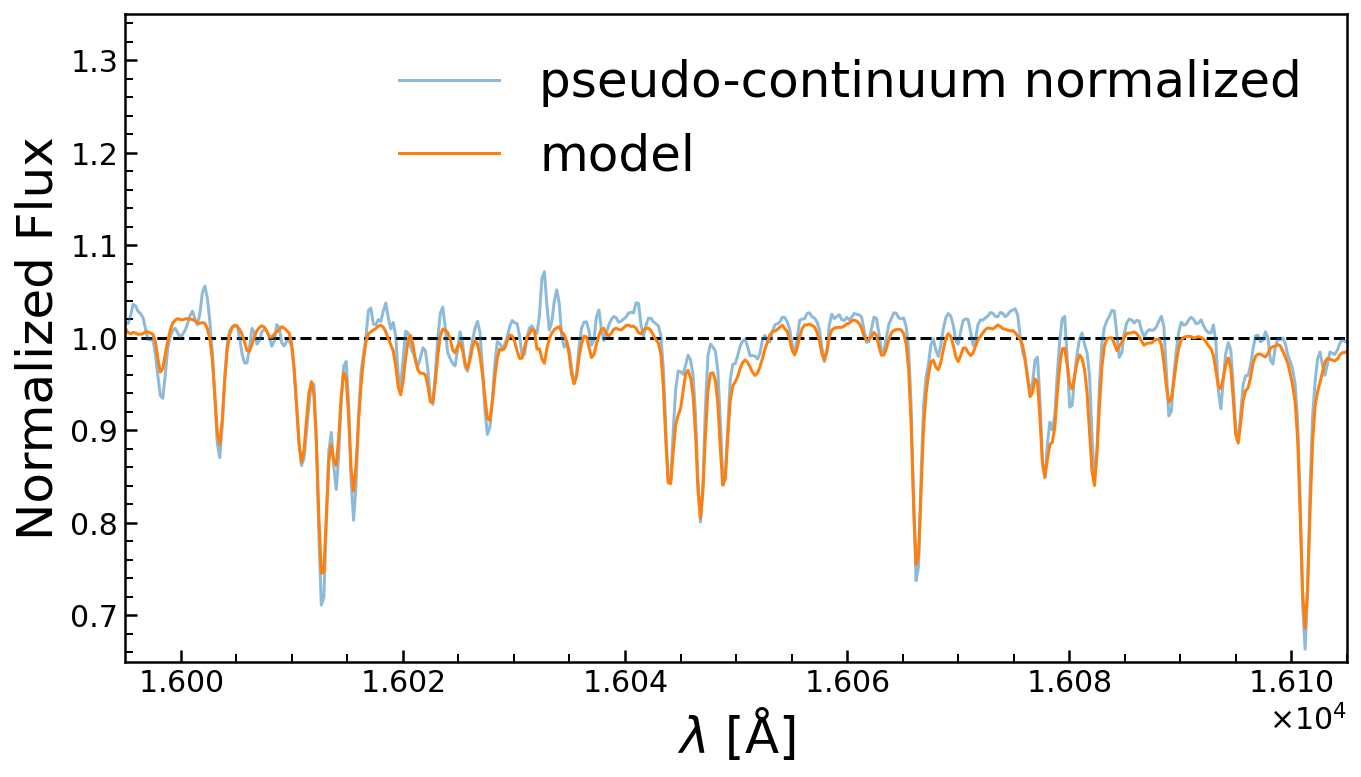

In [514]:
star7_name_field = 'K2_C4_168-21/apStar-r12-2M03533659+2512012.fits'
star7_path = 'data/apStar/K2_C4_168-21/apStar-r12-2M03533659+2512012.fits'

star7_spc_model = model_spectrum(star7_name_field)

plt.figure(figsize=(10,6))

plot_pseudo_norm_spectrum(star7_path, apogee_chips, poly_order=2)

plt.plot(wavelengths_list_train[0], star7_spc_model, linewidth=1.5, label='model')

plt.xlim(15995, 16105)
plt.ylim(0.65, 1.35)
plt.minorticks_on()
plt.legend(frameon=False, fontsize=25)
plt.tight_layout()
# plt.savefig(
#     figures_dir + 'results_star7_spec_pseudo_vs_model.pdf',
#     format='pdf'
# )
plt.show()

# 8.

***For each of the five labels $\ell_i$, plot the gradient spectrum ${\rm d}f_{\lambda}/{\rm d}\ell_i$. This allows the identification of wavelengths that are most sensitive to a particular label. For the gradient spectra of $\rm Si$ and $\rm Mg$, mark the locations of strong known $\rm Si$ and $\rm Mg$ lines.***

*Some well-known lines at $\texttt{APOGEE}$ wavelengths can be found [here](https://github.com/jobovy/apogee/blob/main/apogee/spec/plot.py).*

In [191]:
def get_gradient(file_name, label_index, e):
    
    spectrum_model = model_spectrum(file_name)
    
    file_index = allStar_file_names_list.index(file_name)
    
    # rescale labels with means of training data
    labels = [
        allStar_field_df.iloc[file_index]['TEFF'] - Teff_mean,
        allStar_field_df.iloc[file_index]['LOGG'] - logg_mean,
        allStar_field_df.iloc[file_index]['FE_H'] - FeH_mean,
        allStar_field_df.iloc[file_index]['MG_FE'] - MgFe_mean,
        allStar_field_df.iloc[file_index]['SI_FE'] - SiFe_mean
    ]
    
    # add the displacement to the chosen label
    labels[label_index] += e
    
    # construct label vector
    row = [1] + labels
    for i in range(len(labels)):
        for j in range(i, len(labels)):
            row.append(labels[i] * labels[j])
    
    spectrum_model_list_e = []

    for wavelength_bin in range(len(thetas_matrix)):
        flux_model_value = np.matmul(row, thetas_matrix[wavelength_bin])
        spectrum_model_list_e.append(flux_model_value)
    
    spectrum_model_e = np.array(spectrum_model_list_e)
    
    # compute gradient
    gradient = (spectrum_model_e - spectrum_model) / e
    
    return gradient

def get_gradient_Teff(file_name):
    return get_gradient(file_name, 0, 1e-2)

def get_gradient_logg(file_name):
    return get_gradient(file_name, 1, 1e-3)

def get_gradient_FeH(file_name):
    return get_gradient(file_name, 2, 1e-4)

def get_gradient_MgFe(file_name):
    return get_gradient(file_name, 3, 1e-4)

def get_gradient_SiFe(file_name):
    return get_gradient(file_name, 4, 1e-4)

In [532]:
FeH_absorption_lines = [
    15194.492, 15207.526, 15395.718, 15490.339,
    15648.510, 15964.867, 16040.657, 16153.247,
    16165.032
]

MgFe_absorption_lines = [
    15740.716, 15748.9, 15765.8,
    15879.5, 15886.2, 15954.477
]

SiFe_absorption_lines = [
    15361.161, 15376.831, 15833.602, 15960.063,
    16060.009, 16094.787, 16215.670, 16680.770,
    16828.159
]

def air_to_vacuum(wavelength_air):
    s = 1e4 / wavelength_air
    n = 1 + 0.00008336624212083 + 0.02408926869968 / (130.1065924522 - s**2) + 0.0001599740894897 / (38.92568793293 - s**2)
    
    wavelength_vacuum = wavelength_air * n
    
    return wavelength_vacuum

FeH_abs_lines_vac = []
MgFe_abs_lines_vac = []
SiFe_abs_lines_vac = []

for line in FeH_absorption_lines:
    line_vac = air_to_vacuum(line)
    FeH_abs_lines_vac.append(line_vac)

for line in MgFe_absorption_lines:
    line_vac = air_to_vacuum(line)
    MgFe_abs_lines_vac.append(line_vac)

for line in SiFe_absorption_lines:
    line_vac = air_to_vacuum(line)
    SiFe_abs_lines_vac.append(line_vac)

In [530]:
# print(FeH_abs_lines_vac)
# print()
# print(MgFe_abs_lines_vac)
# print()
print(SiFe_abs_lines_vac)

[15365.358844569586, 15381.03310636554, 15837.928344152637, 15964.423743423138, 16064.396931090243, 16099.184391703018, 16220.100276044208, 16685.32680903405, 16832.75591010622]


In [521]:
def air_to_vacuum(wavelength_air):
    s = 1e4 / wavelength_air
    n = 1 + 0.00008336624212083 + 0.02408926869968 / (130.1065924522 - s**2) + 0.0001599740894897 / (38.92568793293 - s**2)
    
    wavelength_vacuum = wavelength_air * n
    
    return wavelength_vacuum

def plot_gradient(file_name, label_name, gradient, label_units=None, absorption_lines=None):
    
    flux_units = r'$\left[10^{-17} \rm \frac{erg}{{s\,cm^2}\,\AA}\right]$'
    
    plt.plot(wavelengths_list_train[0], gradient, linewidth=1.5)
    plt.title(fr'd$f$ / d{label_name}')
    
    if label_units:
        plt.ylabel(f'{flux_units} / {label_units}')
    
    if absorption_lines:
        for wavelength_air in absorption_lines:
            wavelength_vacuum = air_to_vacuum(wavelength_air)
            plt.axvline(x=wavelength_vacuum, color='r', linestyle='--')
#         for line in absorption_lines:
#             plt.axvline(x=line, color='r', linestyle='--')
    
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
    plt.minorticks_on()
    
def plot_gradient_Teff(file_name):
    gradient_Teff = get_gradient_Teff(file_name)
    
    plot_gradient(file_name, r'$T_{\rm eff}$', gradient_Teff, '[K]')

def plot_gradient_logg(file_name):
    gradient_logg = get_gradient_logg(file_name)
    
    plot_gradient(file_name, r'$\log g$', gradient_logg, r'[$\rm cm/s^2$]')

def plot_gradient_FeH(file_name):
    gradient_FeH = get_gradient_FeH(file_name)
    
    FeH_absorption_lines = [
        15194.492, 15207.526, 15395.718, 15490.339,
        15648.510, 15964.867, 16040.657, 16153.247,
        16165.032
    ]
    
    plot_gradient(
        file_name,
        '[Fe/H]',
        gradient_FeH,
        '[dex]',
        absorption_lines=FeH_absorption_lines
    )

def plot_gradient_MgFe(file_name):
    gradient_MgFe = get_gradient_MgFe(file_name)

    MgFe_absorption_lines = [
        15740.716, 15748.9, 15765.8,
        15879.5, 15886.2, 15954.477
    ]
    
    plot_gradient(
        file_name,
        '[Mg/Fe]',
        gradient_MgFe,
        absorption_lines=MgFe_absorption_lines
    )

def plot_gradient_SiFe(file_name):
    gradient_SiFe = get_gradient_SiFe(file_name)
    
    SiFe_absorption_lines = [
        15361.161, 15376.831, 15833.602, 15960.063,
        16060.009, 16094.787, 16215.670, 16680.770,
        16828.159
    ]
    
    plot_gradient(
        file_name,
        '[Si/Fe]',
        gradient_SiFe,
        absorption_lines=SiFe_absorption_lines
    )

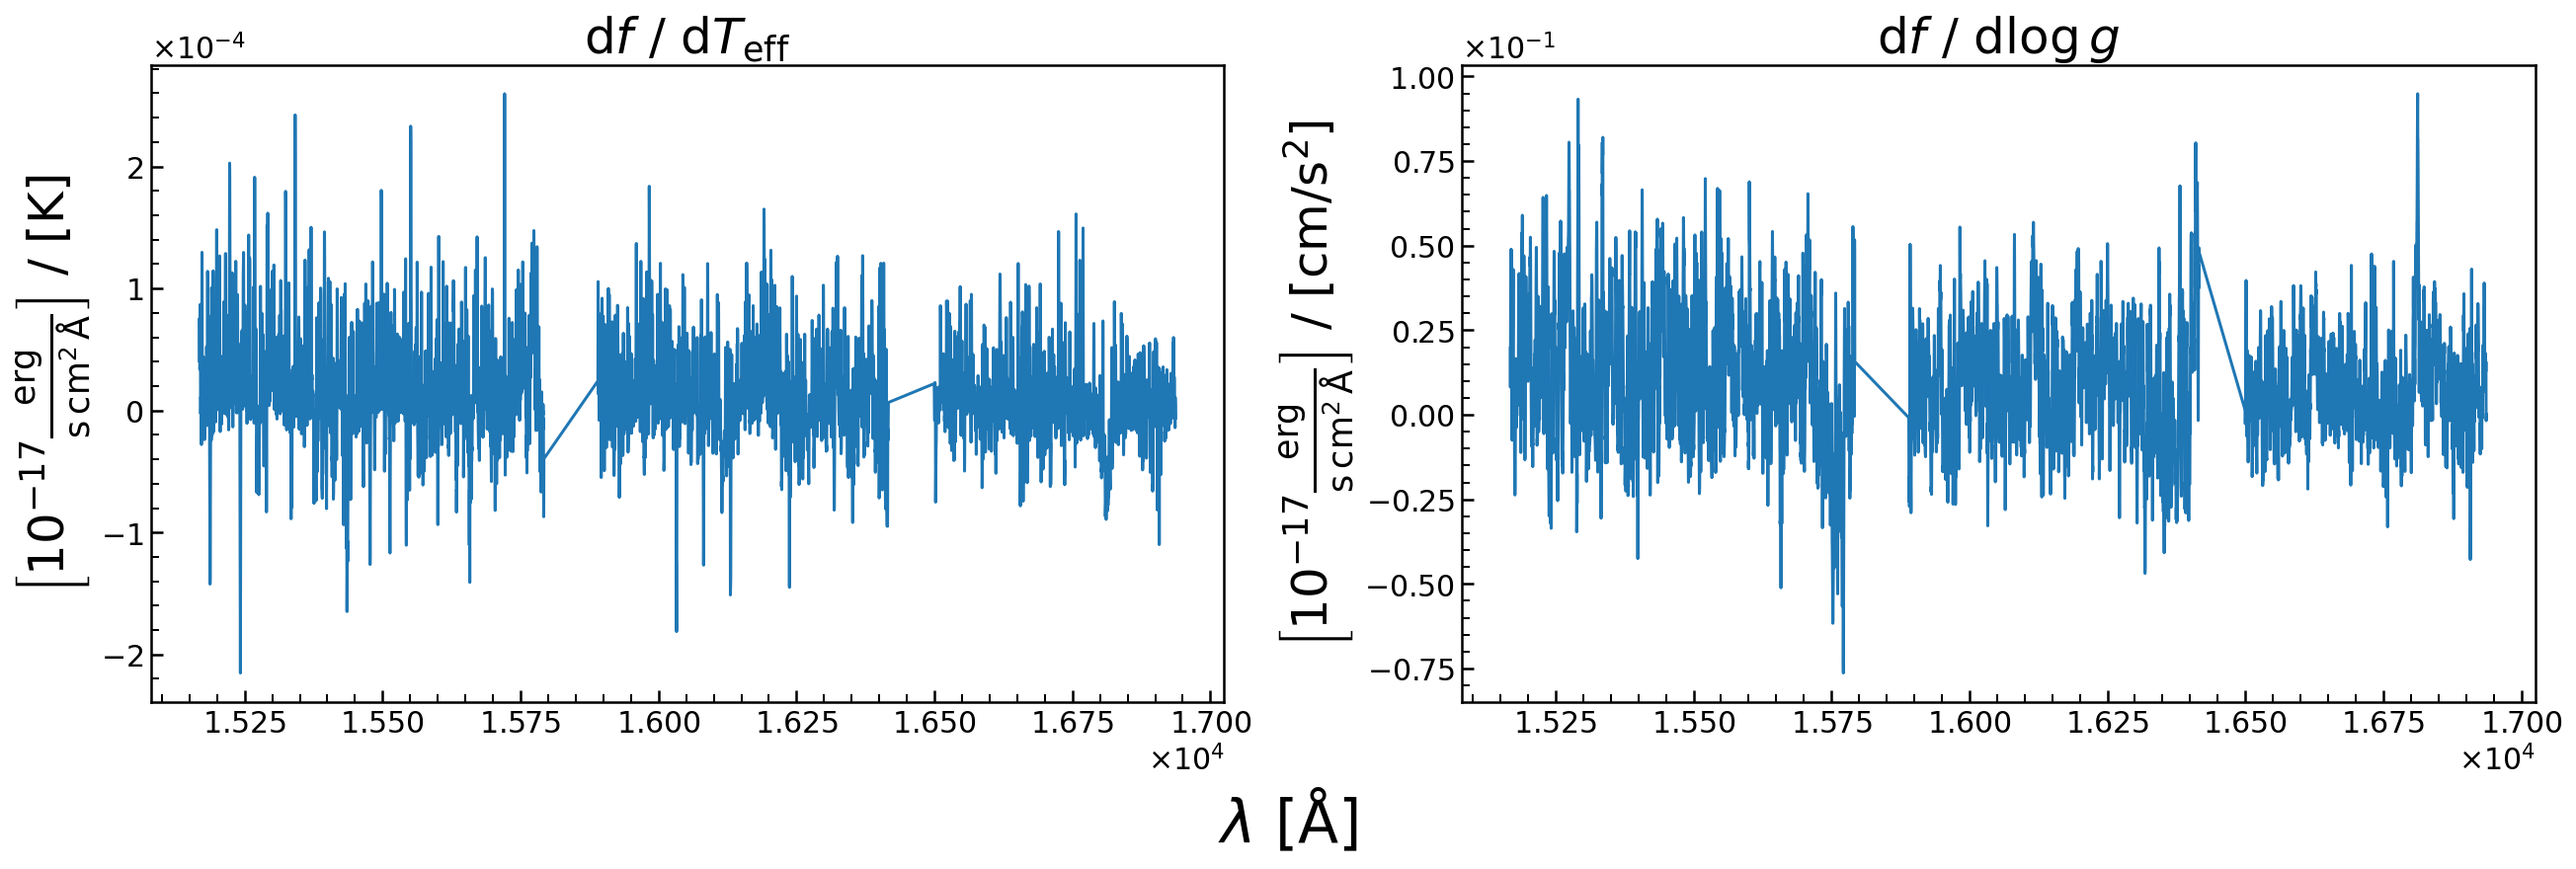

In [515]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6), layout='constrained')
fig.supxlabel(r'$\lambda$ $\left[\rm \AA\right]$')
# fig.suptitle('K2_C4_168-21/2M03533659+2512012')

plt.sca(axs[0])
plot_gradient_Teff(star7_name_field)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0), useMathText=True)

plt.sca(axs[1])
plot_gradient_logg(star7_name_field)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0), useMathText=True)

# plt.savefig(
#     figures_dir + 'results_star7_teff_logg_gradients.pdf',
#     format='pdf'
# )

plt.show()

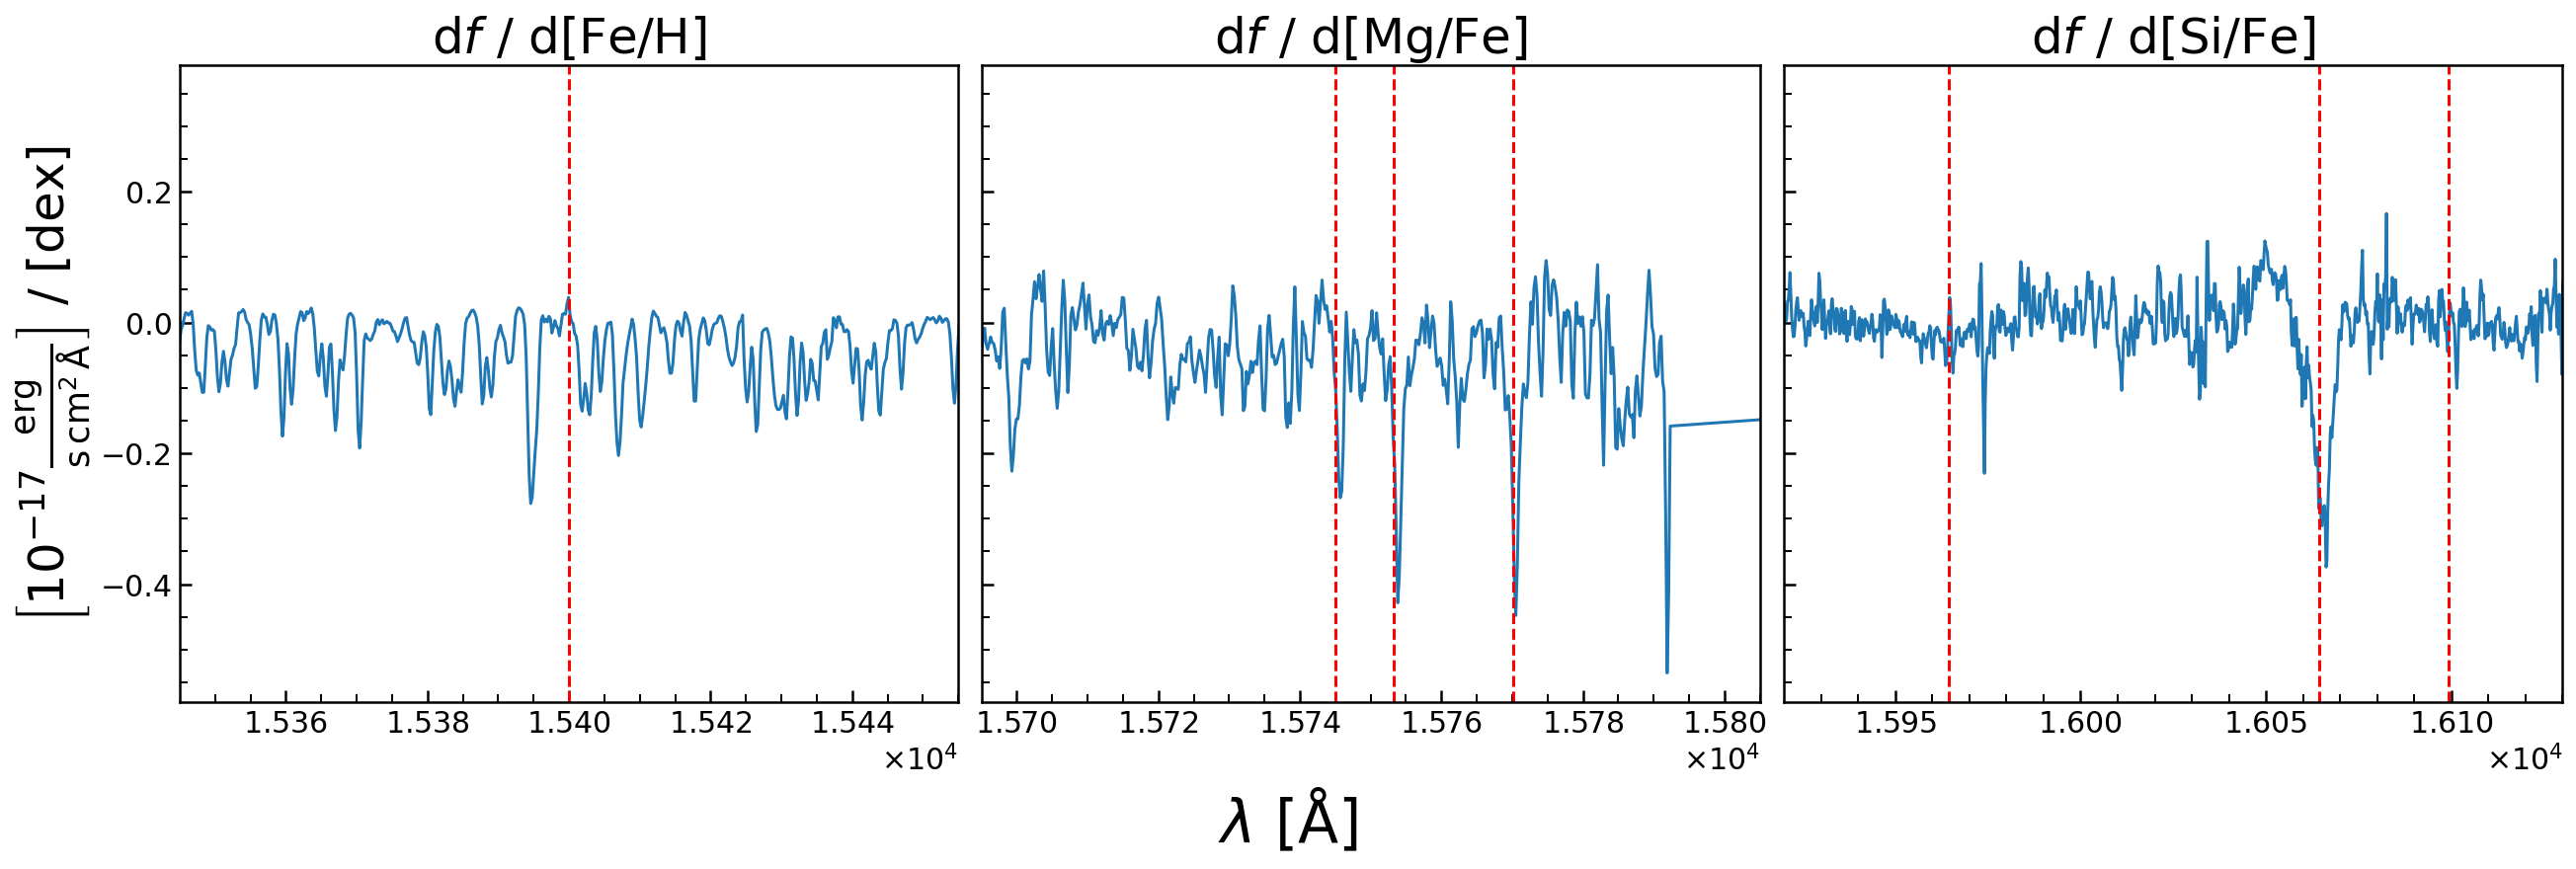

In [524]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True, layout='constrained')
fig.supxlabel(r'$\lambda$ $\left[\rm \AA\right]$')
# fig.suptitle('K2_C4_168-21/2M03533659+2512012')

plt.sca(axs[0])
plot_gradient_FeH(star7_name_field)
plt.xlim(15345, 15455)

plt.sca(axs[1])
plot_gradient_MgFe(star7_name_field)
plt.xlim(15695, 15805)

plt.sca(axs[2])
plot_gradient_SiFe(star7_name_field)
plt.xlim(15920, 16130)

# plt.savefig(
#     figures_dir + 'results_star7_chem_gradients.pdf',
#     format='pdf'
# )

plt.show()

***Do the regions of the spectrum where the gradient is large correspond to known absorption lines?***

***Additionally, plot $s_{\lambda}^2$.***

0.00016945725328516755


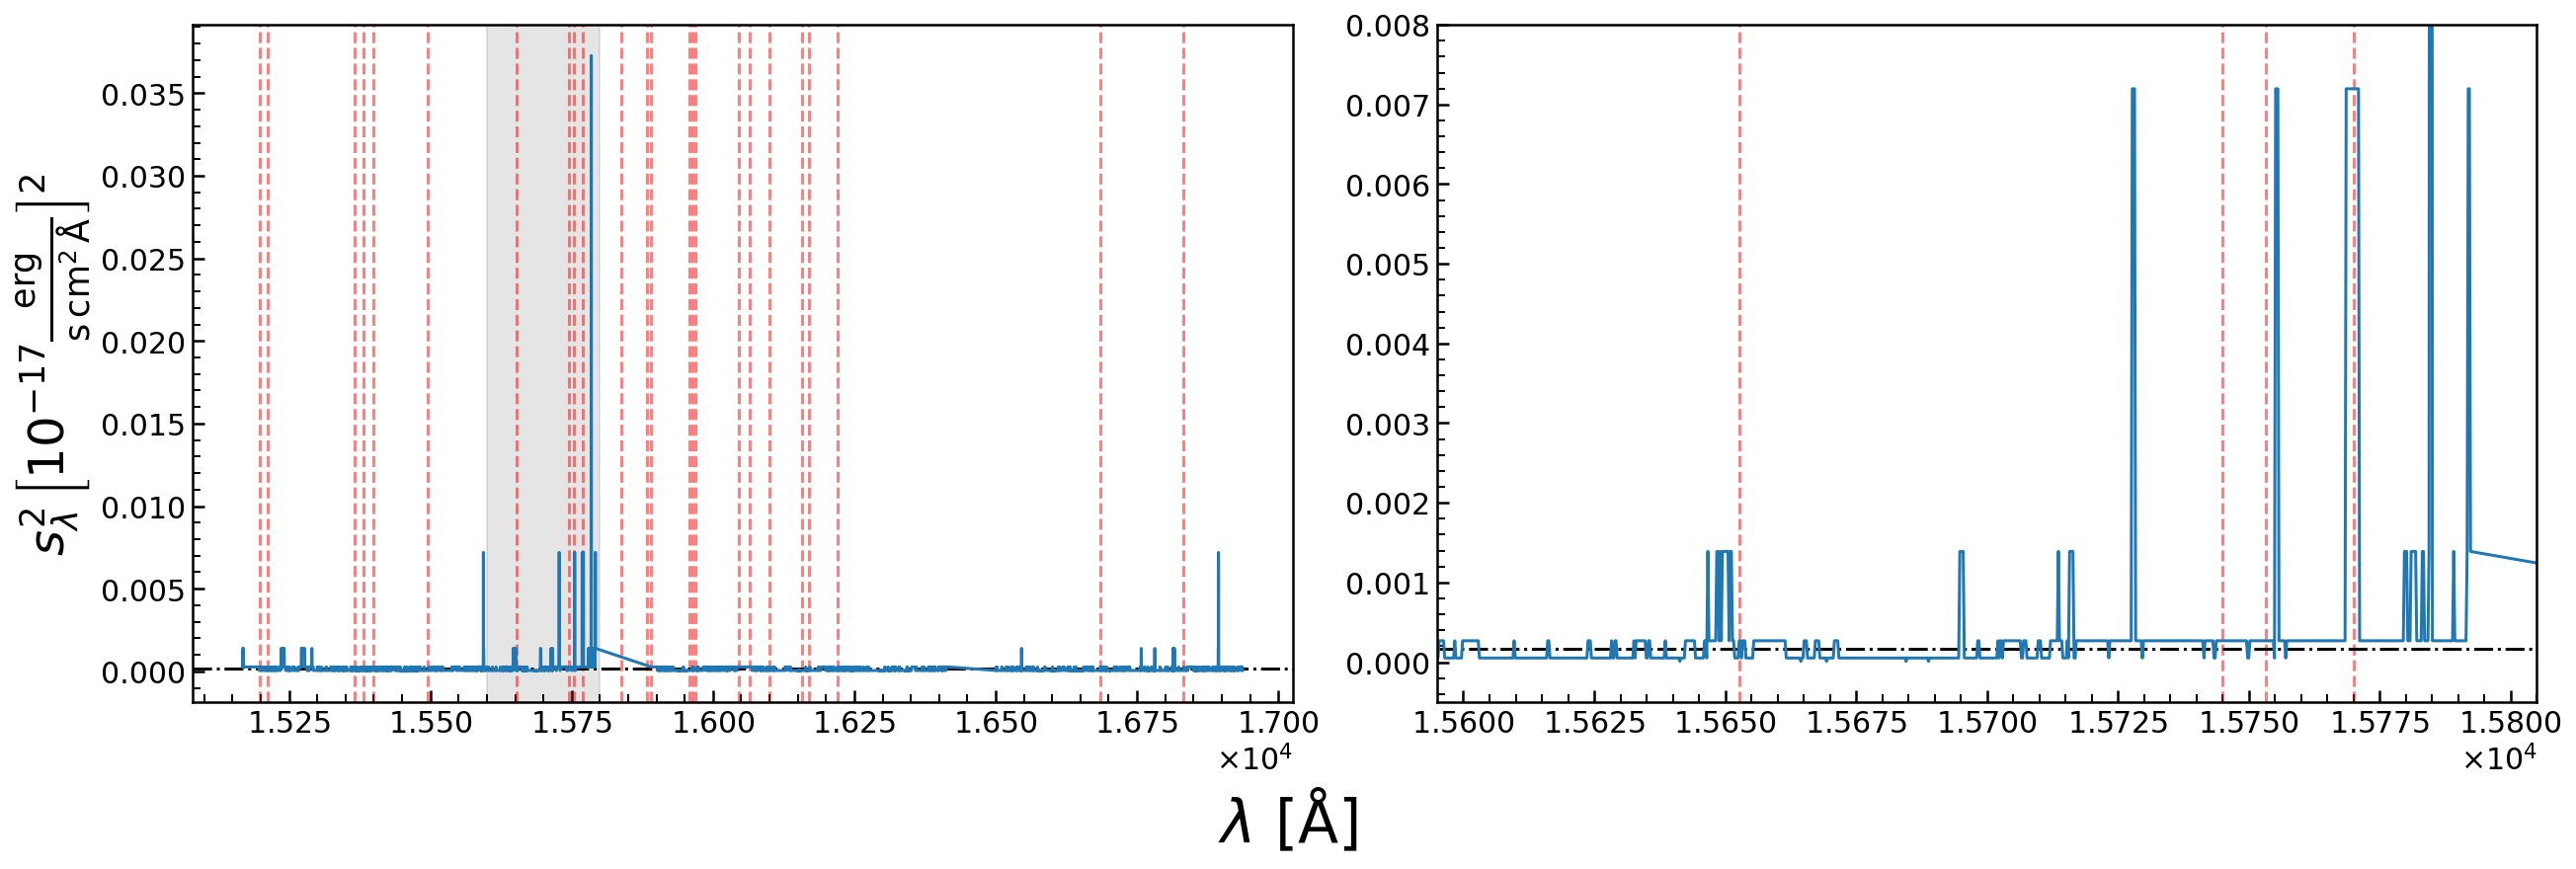

In [556]:
absorption_lines = {
    'FeH': FeH_abs_lines_vac,
    'MgFe': MgFe_abs_lines_vac,
    'SiFe': SiFe_abs_lines_vac
}

intrinsic_scatter_sq_list = [x**2 for x in intrinsic_scatter_list]

scatter_mean = np.mean(np.array(intrinsic_scatter_sq_list))
print(scatter_mean)

fig, axs = plt.subplots(1, 2, figsize=(18, 6), layout='constrained')
fig.supxlabel(r'$\lambda$ $\left[\rm \AA\right]$')

for lines in absorption_lines.values():
    for line in lines:
        axs[0].axvline(x=line, c='r', linestyle='--', alpha=0.5)
        axs[1].axvline(x=line, c='r', linestyle='--', alpha=0.5)

axs[0].axvspan(15600, 15800, color='gray', alpha=0.2)
axs[0].axhline(scatter_mean, linewidth=1.5, linestyle='-.', c='black')
axs[0].plot(
    wavelengths_list_train[0],
    intrinsic_scatter_sq_list,
    linewidth=1.5
)
axs[0].set_ylabel(r'$s_{\lambda}^2 \, \left[10^{-17} \rm \frac{erg}{{s\,cm^2}\,\AA}\right]^2$')
# axs[0].set_ylim(-5e-4, 0.01)
axs[0].minorticks_on()
axs[0].ticklabel_format(
    style='sci',
    axis='x',
    scilimits=(0,0),
    useMathText=True
)

axs[1].axhline(scatter_mean, linewidth=1.5, linestyle='-.', c='black')
axs[1].plot(
    wavelengths_list_train[0],
    intrinsic_scatter_sq_list,
    linewidth=1.5
)
axs[1].minorticks_on()
axs[1].set_xlim(15595, 15805)
axs[1].set_ylim(-5e-4, 0.008)
axs[1].ticklabel_format(
    style='sci',
    axis='x',
    scilimits=(0,0),
    useMathText=True
)

# plt.savefig(
#     figures_dir + 'results_intrinsic_scatter.pdf',
#     format='pdf'
# )

plt.show()

***Do wavelengths with larger-than-average intrinsic scatter correspond to known absorption lines?***

# 9. Fit for labels of spectra in testing set

*To test how well the model works, use it to fit for the labels of spectra in the cross-validation set. For each spectrum in the cross-validation set, use a non-linear optimizer (Python has many options, with Trust Region Reflective (trf) in scipy.optimize.curve_fit being very robust) to find the point in label-space at which the spectrum predicted by the model best matches the observed spectrum (in a $\chi^2$ sense, accounting for the uncertainty in the spectrum).*

In [224]:
def flux_fit(thetas, Teff, logg, FeH, MgFe, SiFe):
    
    # rescale labels based on means of training set
    Teff = Teff - Teff_mean
    logg = logg - logg_mean
    FeH = FeH - FeH_mean
    MgFe = MgFe - MgFe_mean
    SiFe = SiFe - SiFe_mean
    
    # label vector
    row = [
        1, Teff, logg, FeH, MgFe, SiFe,
        Teff**2, Teff*logg, Teff*FeH, Teff*MgFe, Teff*SiFe,
        logg**2, logg*FeH, logg*MgFe, logg*SiFe,
        FeH**2, FeH*MgFe, FeH*SiFe,
        MgFe**2, MgFe*SiFe, 
        SiFe**2
    ]
    
    flux_fit = np.matmul(thetas, row)
    
    return flux_fit

In [225]:
# best-fit labels
Teff_bf_list = []
logg_bf_list = []
FeH_bf_list = []
MgFe_bf_list = []
SiFe_bf_list = []

Teff_bf_err_list = []
logg_bf_err_list = []
FeH_bf_err_list = []
MgFe_bf_err_list = []
SiFe_bf_err_list = []

# testing set labels
Teff_test_list = []
logg_test_list = []
FeH_test_list = []
MgFe_test_list = []
SiFe_test_list = []

Teff_test_err_list = []
logg_test_err_list = []
FeH_test_err_list = []
MgFe_test_err_list = []
SiFe_test_err_list = []

for index in range(len(label_list_test)):
    sigma_total = np.sqrt(errors_test[index]**2 + intrinsic_scatter**2)
    
    opt, cov = curve_fit(
        flux_fit,
        thetas_matrix,
        spectra_test[index],
        p0=[
            Teff_mean,
            logg_mean,
            FeH_mean,
            MgFe_mean,
            SiFe_mean
        ],
        sigma=sigma_total,
        method='trf',
        maxfev=5000
    )
    
    # best fit parameters
    Teff_bf_list.append(opt[0])
    logg_bf_list.append(opt[1])
    FeH_bf_list.append(opt[2])
    MgFe_bf_list.append(opt[3])
    SiFe_bf_list.append(opt[4])
    
    # fit errors
    Teff_bf_err_list.append(cov[0,0])
    logg_bf_err_list.append(cov[1,1])
    FeH_bf_err_list.append(cov[2,2])
    MgFe_bf_err_list.append(cov[3,3])
    SiFe_bf_err_list.append(cov[4,4])
    
    # testing set labels
    Teff_test_list.append(label_list_test.iloc[index]['TEFF'])
    logg_test_list.append(label_list_test.iloc[index]['LOGG'])
    FeH_test_list.append(label_list_test.iloc[index]['FE_H'])
    MgFe_test_list.append(label_list_test.iloc[index]['MG_FE'])
    SiFe_test_list.append(label_list_test.iloc[index]['SI_FE'])
    
    Teff_test_err_list.append(label_list_test.iloc[index]['TEFF_ERR'])
    logg_test_err_list.append(label_list_test.iloc[index]['LOGG_ERR'])
    FeH_test_err_list.append(label_list_test.iloc[index]['FE_H_ERR'])
    MgFe_test_err_list.append(label_list_test.iloc[index]['MG_FE_ERR'])
    SiFe_test_err_list.append(label_list_test.iloc[index]['SI_FE_ERR'])
    
# convert lists to arrays
Teff_bf = np.array(Teff_bf_list)
Teff_bf_err = np.array(Teff_bf_err_list)
Teff_test = np.array(Teff_test_list)
Teff_test_err = np.array(Teff_test_err_list)

logg_bf = np.array(logg_bf_list)
logg_bf_err = np.array(logg_bf_err_list)
logg_test = np.array(logg_test_list)
logg_test_err = np.array(logg_test_err_list)

FeH_bf = np.array(FeH_bf_list)
FeH_bf_err = np.array(FeH_bf_err_list)
FeH_test = np.array(FeH_test_list)
FeH_test_err = np.array(FeH_test_err_list)

MgFe_bf = np.array(MgFe_bf_list)
MgFe_bf_err = np.array(MgFe_bf_err_list)
MgFe_test = np.array(MgFe_test_list)
MgFe_test_err = np.array(MgFe_test_err_list)

SiFe_bf = np.array(SiFe_bf_list)
SiFe_bf_err = np.array(SiFe_bf_err_list)
SiFe_test = np.array(SiFe_test_list)
SiFe_test_err = np.array(SiFe_test_err_list)

# residuals
Teff_residuals = Teff_test - Teff_bf
logg_residuals = logg_test - logg_bf
FeH_residuals = FeH_test - FeH_bf
MgFe_residuals = MgFe_test - MgFe_bf
SiFe_residuals = SiFe_test - SiFe_bf

# bias
Teff_residuals_mean = np.mean(Teff_residuals)
logg_residuals_mean = np.mean(logg_residuals)
FeH_residuals_mean = np.mean(FeH_residuals)
MgFe_residuals_mean = np.mean(MgFe_residuals)
SiFe_residuals_mean = np.mean(SiFe_residuals)

# scatter
Teff_residuals_std = np.std(Teff_residuals)
logg_residuals_std = np.std(logg_residuals)
FeH_residuals_std = np.std(FeH_residuals)
MgFe_residuals_std = np.std(MgFe_residuals)
SiFe_residuals_std = np.std(SiFe_residuals)

*Now compare, for each of the five labels, the best-fit value obtained by the above procedure to the $\texttt{ASPCAP}$-derived value in the allStar catalog for the validation set. That is, make plots of the best-fit labels vs the $\texttt{ASPCAP}$ labels with a one-to-one line for reference, and show the residuals. Measure the ***bias*** and ***scatter*** for each label over the full cross-validation set. For a good model, these should be small; for example, a scatter of about $30 \rm \, K$ in $\rm T_{eff}$ and $0.02 \, \rm dex$ in $\left[\rm Fe/H \right]$ should be achievable.*

In [560]:
hh=10

print(label_list_test.iloc[hh])
print()
print(f'Best fit Teff: {Teff_bf_list[hh]}, Teff_err: {Teff_bf_err_list[hh]}')
print(f'Test Teff: {Teff_test_list[hh]}, Teff_err: {Teff_test_err_list[hh]}')
print()
print(f'Best fit logg: {logg_bf_list[hh]}, logg_err: {logg_bf_err_list[hh]}')
print(f'Test logg: {logg_test_list[hh]}, logg_err: {logg_test_err_list[hh]}')
print()
print(f'Best fit FeH: {FeH_bf_list[hh]}, FeH_err: {FeH_bf_err_list[hh]}')
print(f'Test FeH: {FeH_test_list[hh]}, FeH_err: {FeH_test_err_list[hh]}')
print()
print(f'Best fit MgFe: {MgFe_bf_list[hh]}, MgFe_err: {MgFe_bf_err_list[hh]}')
print(f'Test MgFe: {MgFe_test_list[hh]}, MgFe_err: {MgFe_test_err_list[hh]}')
print()
print(f'Best fit SiFe: {SiFe_bf_list[hh]}, SiFe_err: {SiFe_bf_err_list[hh]}')
print(f'Test SiFe: {SiFe_test_list[hh]}, SiFe_err: {SiFe_test_err_list[hh]}')

FILE          apStar-r12-2M21345439+1141389.fits
APOGEE_ID                     2M21345439+1141389
FIELD                                        M15
SNR                                   155.705994
TEFF                                 4706.957031
TEFF_ERR                               92.487625
LOGG                                    2.434605
LOGG_ERR                                0.066976
ASPCAPFLAG                                     0
MG_FE                                   0.233692
SI_FE                                   0.147212
FE_H                                   -0.535502
MG_FE_ERR                               0.014609
SI_FE_ERR                               0.013533
FE_H_ERR                                0.010167
Name: 1841, dtype: object

Best fit Teff: 4698.77937710454, Teff_err: 24.563957011581252
Test Teff: 4706.95703125, Teff_err: 92.48762512207031

Best fit logg: 2.450979788521915, logg_err: 0.00016654780355778562
Test logg: 2.4346048831939697, logg_err: 0.06697622686

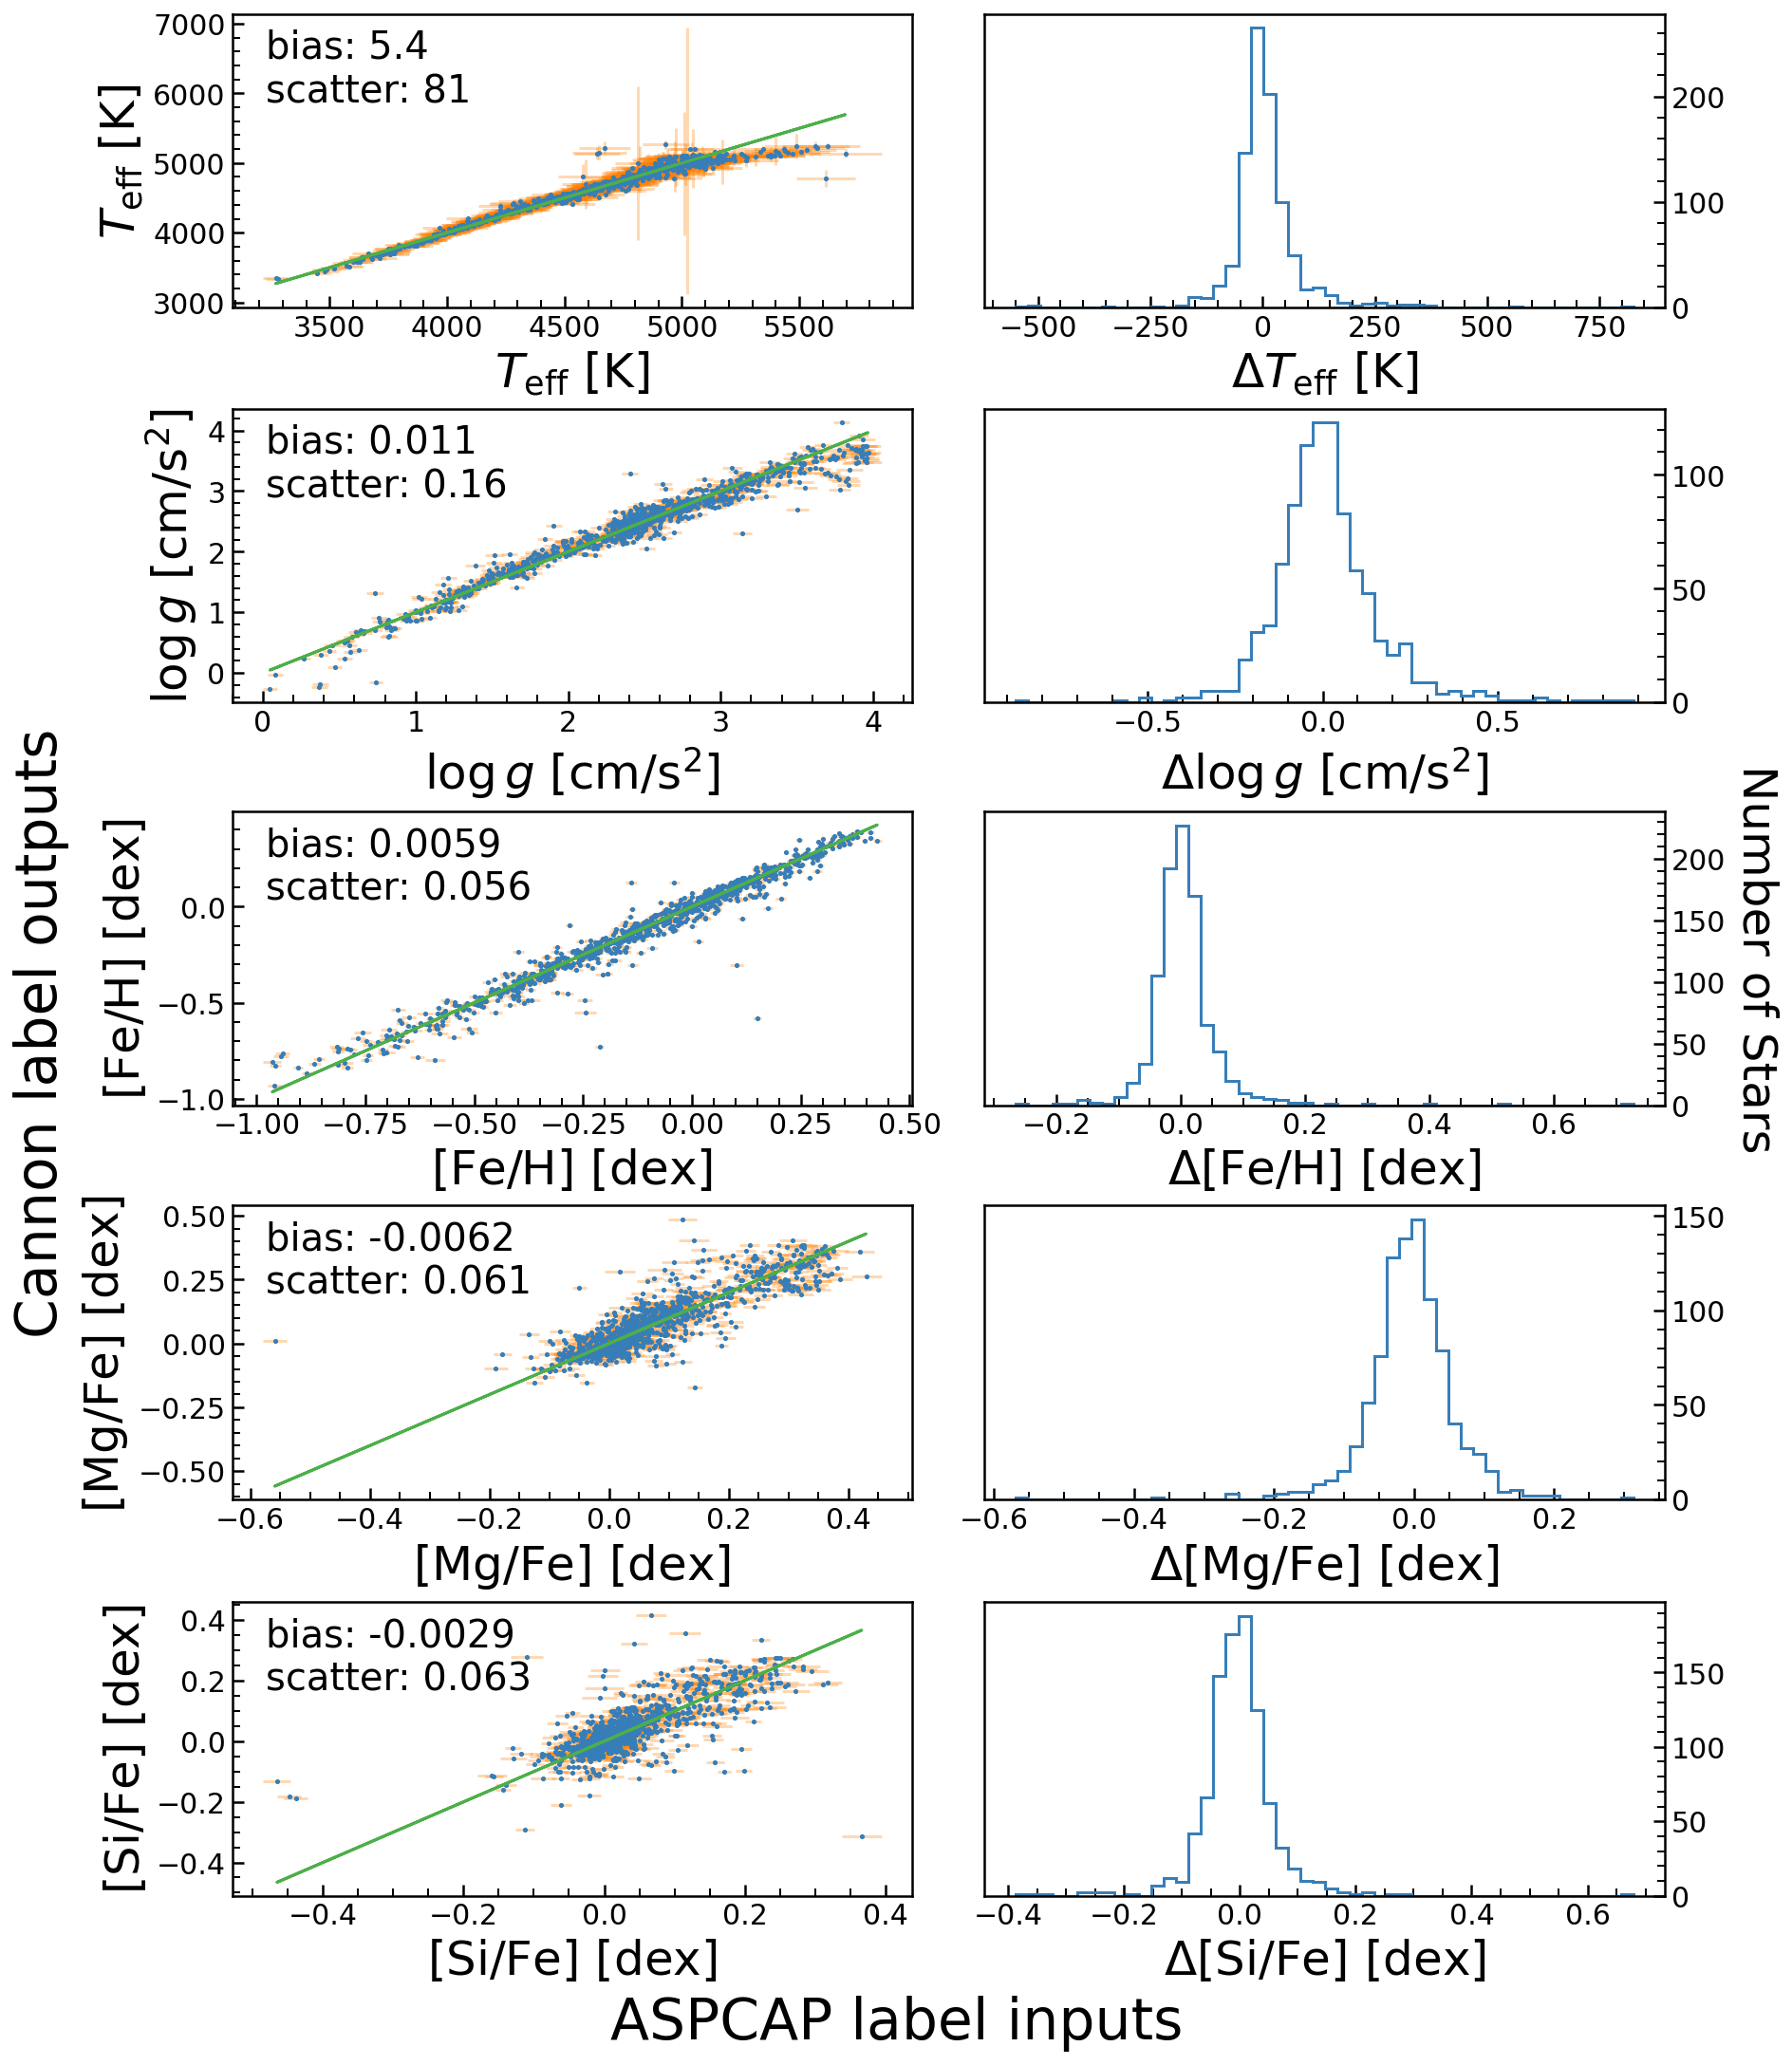

In [393]:
data_lists = [
    (
        Teff_test,
        Teff_bf,
        Teff_test_err,
        Teff_bf_err,
        Teff_residuals,
        Teff_residuals_mean,
        Teff_residuals_std,
        r'$T_{\rm eff}$ [K]',
        r'$T_{\rm eff}$ [K]',
        r'$\Delta T_{\rm eff}$ [K]'
    ),
    (
        logg_test,
        logg_bf,
        logg_test_err,
        logg_bf_err,
        logg_residuals,
        logg_residuals_mean,
        logg_residuals_std,
        r'$\log g$ [$\rm cm/s^2$]',
        r'$\log g$ [$\rm cm/s^2$]',
        r'$\Delta \log g$ [$\rm cm/s^2$]'
    ),
    (
        FeH_test,
        FeH_bf,
        FeH_test_err,
        FeH_bf_err,
        FeH_residuals,
        FeH_residuals_mean,
        FeH_residuals_std,
        r'$\left[\rm Fe/H\right]$ [dex]',
        r'$\left[\rm Fe/H\right]$ [dex]',
        r'$\Delta \left[\rm Fe/H\right]$ [dex]'
    ),
    (
        MgFe_test,
        MgFe_bf,
        MgFe_test_err,
        MgFe_bf_err,
        MgFe_residuals,
        MgFe_residuals_mean,
        MgFe_residuals_std,
        r'$\left[\rm Mg/Fe\right]$ [dex]',
        r'$\left[\rm Mg/Fe\right]$ [dex]',
        r'$\Delta \left[\rm Mg/Fe\right]$ [dex]'
    ),
    (
        SiFe_test,
        SiFe_bf,
        SiFe_test_err,
        SiFe_bf_err,
        SiFe_residuals,
        SiFe_residuals_mean,
        SiFe_residuals_std,
        r'$\left[\rm Si/Fe\right]$ [dex]',
        r'$\left[\rm Si/Fe\right]$ [dex]',
        r'$\Delta \left[\rm Si/Fe\right]$ [dex]'
    )
]

fig, axs = plt.subplots(5, 2, figsize=(13, 15), layout='constrained')
# fig.suptitle('APOGEE Labels: Model Fit vs. ASPCAP')
fig.supxlabel('ASPCAP label inputs')
fig.supylabel('Cannon label outputs')

for i, (
    x_data, y_data,
    x_err, y_err,
    residuals, residuals_mean, residuals_std,
    xlabel, ylabel, residuals_label
) in enumerate(data_lists):
    row = i
    col = 0
    ax = axs[row, col]
    
    ax.errorbar(
        x_data,
        y_data,
        xerr=x_err,
        yerr=y_err,
        fmt='none',
        elinewidth=1.5,
        ecolor=CB_color_cycle[1],
        alpha=0.3,
        zorder=0
    )
    ax.scatter(x_data, y_data, marker='.', s=10, c=CB_color_cycle[0])
    ax.plot(x_data, x_data, linewidth=1.5, c=CB_color_cycle[2])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
#     ax.ticklabel_format(
#         style='sci',
#         axis='both',
#         scilimits=(0,0),
#         useMathText=True
#     )
    ax.minorticks_on()
    
    bias_formatted = '{:.2g}'.format(residuals_mean)
    scatter_formatted = '{:.2g}'.format(residuals_std)

    bias_scatter_text = f'bias: {bias_formatted}\nscatter: {scatter_formatted}'
    ax.text(0.05, 0.95, bias_scatter_text, transform=ax.transAxes, va='top', fontsize=20)

    # plot residuals
    col = 1
    ax = axs[row, col]
    ax.hist(residuals, bins=50, histtype='step', linewidth=1.5, color=CB_color_cycle[0], orientation='vertical')
    ax.set_xlabel(residuals_label)
    ax.yaxis.set_label_position('right')
    ax.yaxis.tick_right()
    ax.minorticks_on()

axs[2,1].set_ylabel('Number of Stars', rotation=270, va='bottom')

# plt.savefig(
#     figures_dir + 'results_apogee_labels_fit_vs_aspcap.pdf',
#     format='pdf'
# )

plt.show()

# 10.

*Although the model should perform well in cross-validation in most cases, there are likely a few objects for which the best-fit labels differ substantially from those in the allStar catalog.* ***Investigate these objects, and try to find out what has gone wrong. Did the optimizer get stuck in a local minimum? Is there something wrong with the spectrum or continuum normalization? Are there flags in the catalog indicating the allStar labels might not be reliable? Can you improve your model based on these tests?***

# 11.

***For the ~900 stars in the cross-validation set, plot a Kiel diagram (i.e. logg vs Teff). Color points by their Fe/H. Use labels obtained through fitting, not the ASPCAP labels. Identify known features. Comment on the presence (or absence) of trends with Fe/H.***

*The paper by [Holtzman et al. (2015)](https://ui.adsabs.harvard.edu/abs/2015AJ....150..148H/abstract) should give a sense of what this is expected to look like.*

***Download and overplot a 6 Gyr-old [MIST](https://waps.cfa.harvard.edu/MIST/interp_isos.html) isochrone of solar metallicity $\left[\rm Fe/H\right] = 0$. Are the isochrones and model in good agreement? Also plot an isochrone with $\left[\rm Fe/H\right] = -1$. Does the $\left[\rm Fe/H\right]$-trend in the isochrones agree with what you found in your fitting?***

In [234]:
# 6 Gyr isochrone, solar metallicity
Zsolar_iso = Table.read(
    'data/MIST_isochrones/MIST_iso_66071946a2439.iso',
    format='ascii',
    header_start = -1
)

# 6 Gyr isochrone, [Fe/H] = -1
Zng1_iso = Table.read(
    'data/MIST_isochrones/MIST_iso_66071d403b83f.iso',
    format='ascii',
    header_start = -1
)

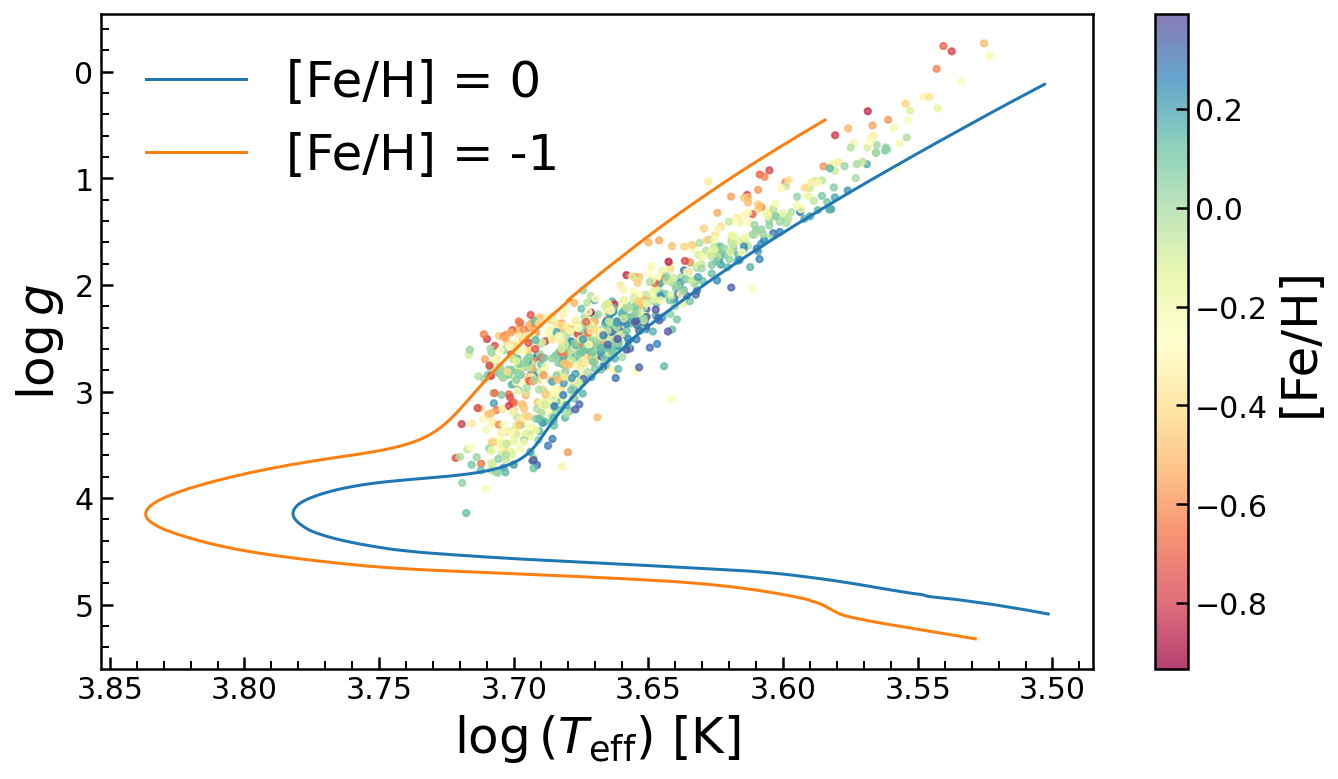

In [397]:
# main sequence labels
Zsolar_logTeff = Zsolar_iso[
    (Zsolar_iso['phase']<=2)&
    (Zsolar_iso['phase']>=-1)
]['log_Teff']
Zsolar_logg = Zsolar_iso[
    (Zsolar_iso['phase']<=2)&
    (Zsolar_iso['phase']>=-1)
]['log_g']

Zng1_logTeff = Zng1_iso[
    (Zng1_iso['phase']<=2)&
    (Zng1_iso['phase']>=-1)
]['log_Teff']

Zng1_logg = Zng1_iso[
    (Zng1_iso['phase']<=2)&
    (Zng1_iso['phase']>=-1)
]['log_g']

plt.figure(figsize=(10,6))
plt.scatter(
    np.log10(Teff_bf),
    logg_bf,
#     marker='.',
    s=10,
    c=FeH_bf,
    cmap='Spectral',
    alpha=0.75
)
    
plt.plot(
    Zsolar_logTeff,
    Zsolar_logg,
    linewidth=1.5,
    label = '[Fe/H] = 0'
)

plt.plot(
    Zng1_logTeff,
    Zng1_logg,
    linewidth=1.5,
    label = '[Fe/H] = -1'
)

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.colorbar(label='[Fe/H]')
plt.xlabel(r'$\log\left(T_{\rm eff}\right)$ [K]')
plt.ylabel(r'$\log g$')
# plt.title(r'Model fit of $\log g$ vs $T_{\rm eff}$')
plt.minorticks_on()
plt.legend(frameon=False, fontsize=25)
plt.tight_layout()
# plt.savefig(
#     figures_dir + 'results_kiel_diagram.pdf',
#     format='pdf'
# )
plt.show()

# 12.

*Wrap the spectral model in MCMC using $\texttt{pymc}$. Then, use it to fit the provided [mystery spectrum](https://github.com/ucb-datalab/course_materials_2024/tree/main/labs/lab2_data). As always, state the priors.*

In [400]:
def plot_pseudo_norm_spectrum(file_path, chip_ranges, poly_order):
    continuum_wavelengths, pseudo_norm_spectra, pseudo_norm_errors = pseudo_continuum_normalize(
        file_path, chip_ranges, poly_order
    )

    plt.axhline(1, linestyle='--', c='black')
    
    for i, (start, end) in enumerate(chip_ranges):
        start_index = np.searchsorted(continuum_wavelengths, start)
        end_index = np.searchsorted(continuum_wavelengths, end)
        
        plt.plot(
            continuum_wavelengths[start_index:end_index],
            pseudo_norm_spectra[start_index:end_index],
            alpha=0.5,
#             label=fr'{start}-{end} $\AA$'
        )
        
#     plt.plot(
#         continuum_wavelengths,
#         pseudo_norm_spectra,
#         alpha=0.5,
#         label=f'pseudo-normalized'
#     )
    
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
    plt.xlabel(r'$\lambda$ $\left[\rm\AA\right]$')
    plt.ylabel('Normalized Flux')
#     plt.legend()

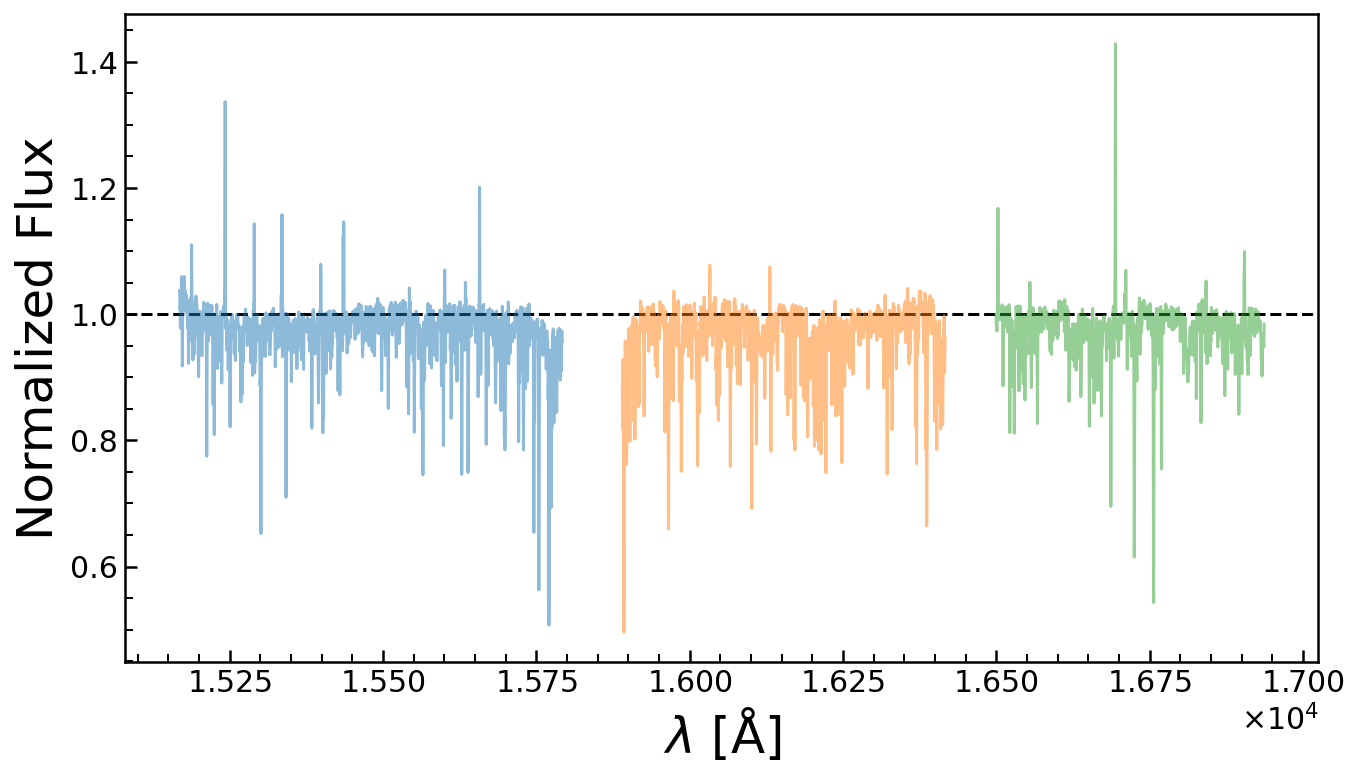

In [402]:
mystery_spec_file_path = 'data/mystery_spec_wiped.fits'

mystery_wvl, mystery_spc, mystery_err = pseudo_continuum_normalize(
    mystery_spec_file_path, apogee_chips, poly_order=2
)

plt.figure(figsize=(10,6))
plot_pseudo_norm_spectrum(
    mystery_spec_file_path,
    apogee_chips,
    poly_order=2
)
# plt.title('Pseudo-normalized mystery spectrum')
plt.minorticks_on()
plt.tight_layout()
# plt.savefig(
#     figures_dir + 'results_mystery_pseudo_norm_spectrum.pdf',
#     format='pdf',
# )
plt.show()

In [561]:
with pm.Model() as model:
    
    # uniform priors
    _Teff_prior = pm.Uniform(r'$T_{\rm eff}$', lower=0, upper=1e4)
    _logg_prior = pm.Uniform(r'$\log g$', lower=0, upper=10)
    _FeH_prior = pm.Uniform('[Fe/H]', lower = -2, upper=2)
    _MgFe_prior = pm.Uniform('[Mg/Fe]', lower = -2, upper=2)
    _SiFe_prior = pm.Uniform('[Si/Fe]', lower = -2, upper=2)
    
    # rescale with means of training set
    _Teff_rescaled = _Teff_prior - Teff_mean
    _logg_rescaled = _logg_prior - logg_mean
    _FeH_rescaled = _FeH_prior - FeH_mean
    _MgFe_rescaled = _MgFe_prior - MgFe_mean
    _SiFe_rescaled = _SiFe_prior - SiFe_mean
    
    # label vector
    _row = [
        1, _Teff_rescaled, _logg_rescaled, _FeH_rescaled, _MgFe_rescaled, _SiFe_rescaled,
        _Teff_rescaled**2, _Teff_rescaled*_logg_rescaled, _Teff_rescaled*_FeH_rescaled, _Teff_rescaled*_MgFe_rescaled, _Teff_rescaled*_SiFe_rescaled,
        _logg_rescaled**2, _logg_rescaled*_FeH_rescaled, _logg_rescaled*_MgFe_rescaled, _logg_rescaled*_SiFe_rescaled,
        _FeH_rescaled**2, _FeH_rescaled*_MgFe_rescaled, _FeH_rescaled*_SiFe_rescaled,
        _MgFe_rescaled**2, _MgFe_rescaled*_SiFe_rescaled, 
        _SiFe_rescaled**2
    ]
    
    # total uncertainty
    _sigma_total = pm.math.sqrt(mystery_err**2 + intrinsic_scatter**2)
    
    # log likelihood terms
    _exp_term = (mystery_spc - pm.math.dot(thetas_matrix_list, _row))**2 / _sigma_total**2
    
    _log_term = pm.math.log(_sigma_total**2)
    
    # explicit implementation of log likelihood
    _log_likelihood = -0.5*_exp_term - 0.5*_log_term
    
    _log_likeli = pm.Potential('log_likelihood', pm.math.sum(_log_likelihood))
    
    _trace = pm.sample(draws=500, tune=500, chains=4, cores=2)

/var/folders/79/pc1qvlln7jv_xsqbggrvys9m0000gn/T/ipykernel_67807/1639693469.py:40: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  _trace = pm.sample(draws=500, tune=500, chains=4, cores=2)
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 2 jobs)
NUTS: [[Si/Fe], [Mg/Fe], [Fe/H], $\log g$, $T_{\rm eff}$]
INFO:pymc3:NUTS: [[Si/Fe], [Mg/Fe], [Fe/H], $\log g$, $T_{\rm eff}$]


/Users/hiennguyen/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/hiennguyen/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/hiennguyen/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/hiennguyen/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 51 seconds.
INFO:pymc3:Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 51 seconds.
The acceptance probability does not match the target.

/var/folders/79/pc1qvlln7jv_xsqbggrvys9m0000gn/T/ipykernel_67807/2110936564.py:3: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  _ = pm.traceplot(_trace, var_names=label_names, figsize=(10,13))
/Users/hiennguyen/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


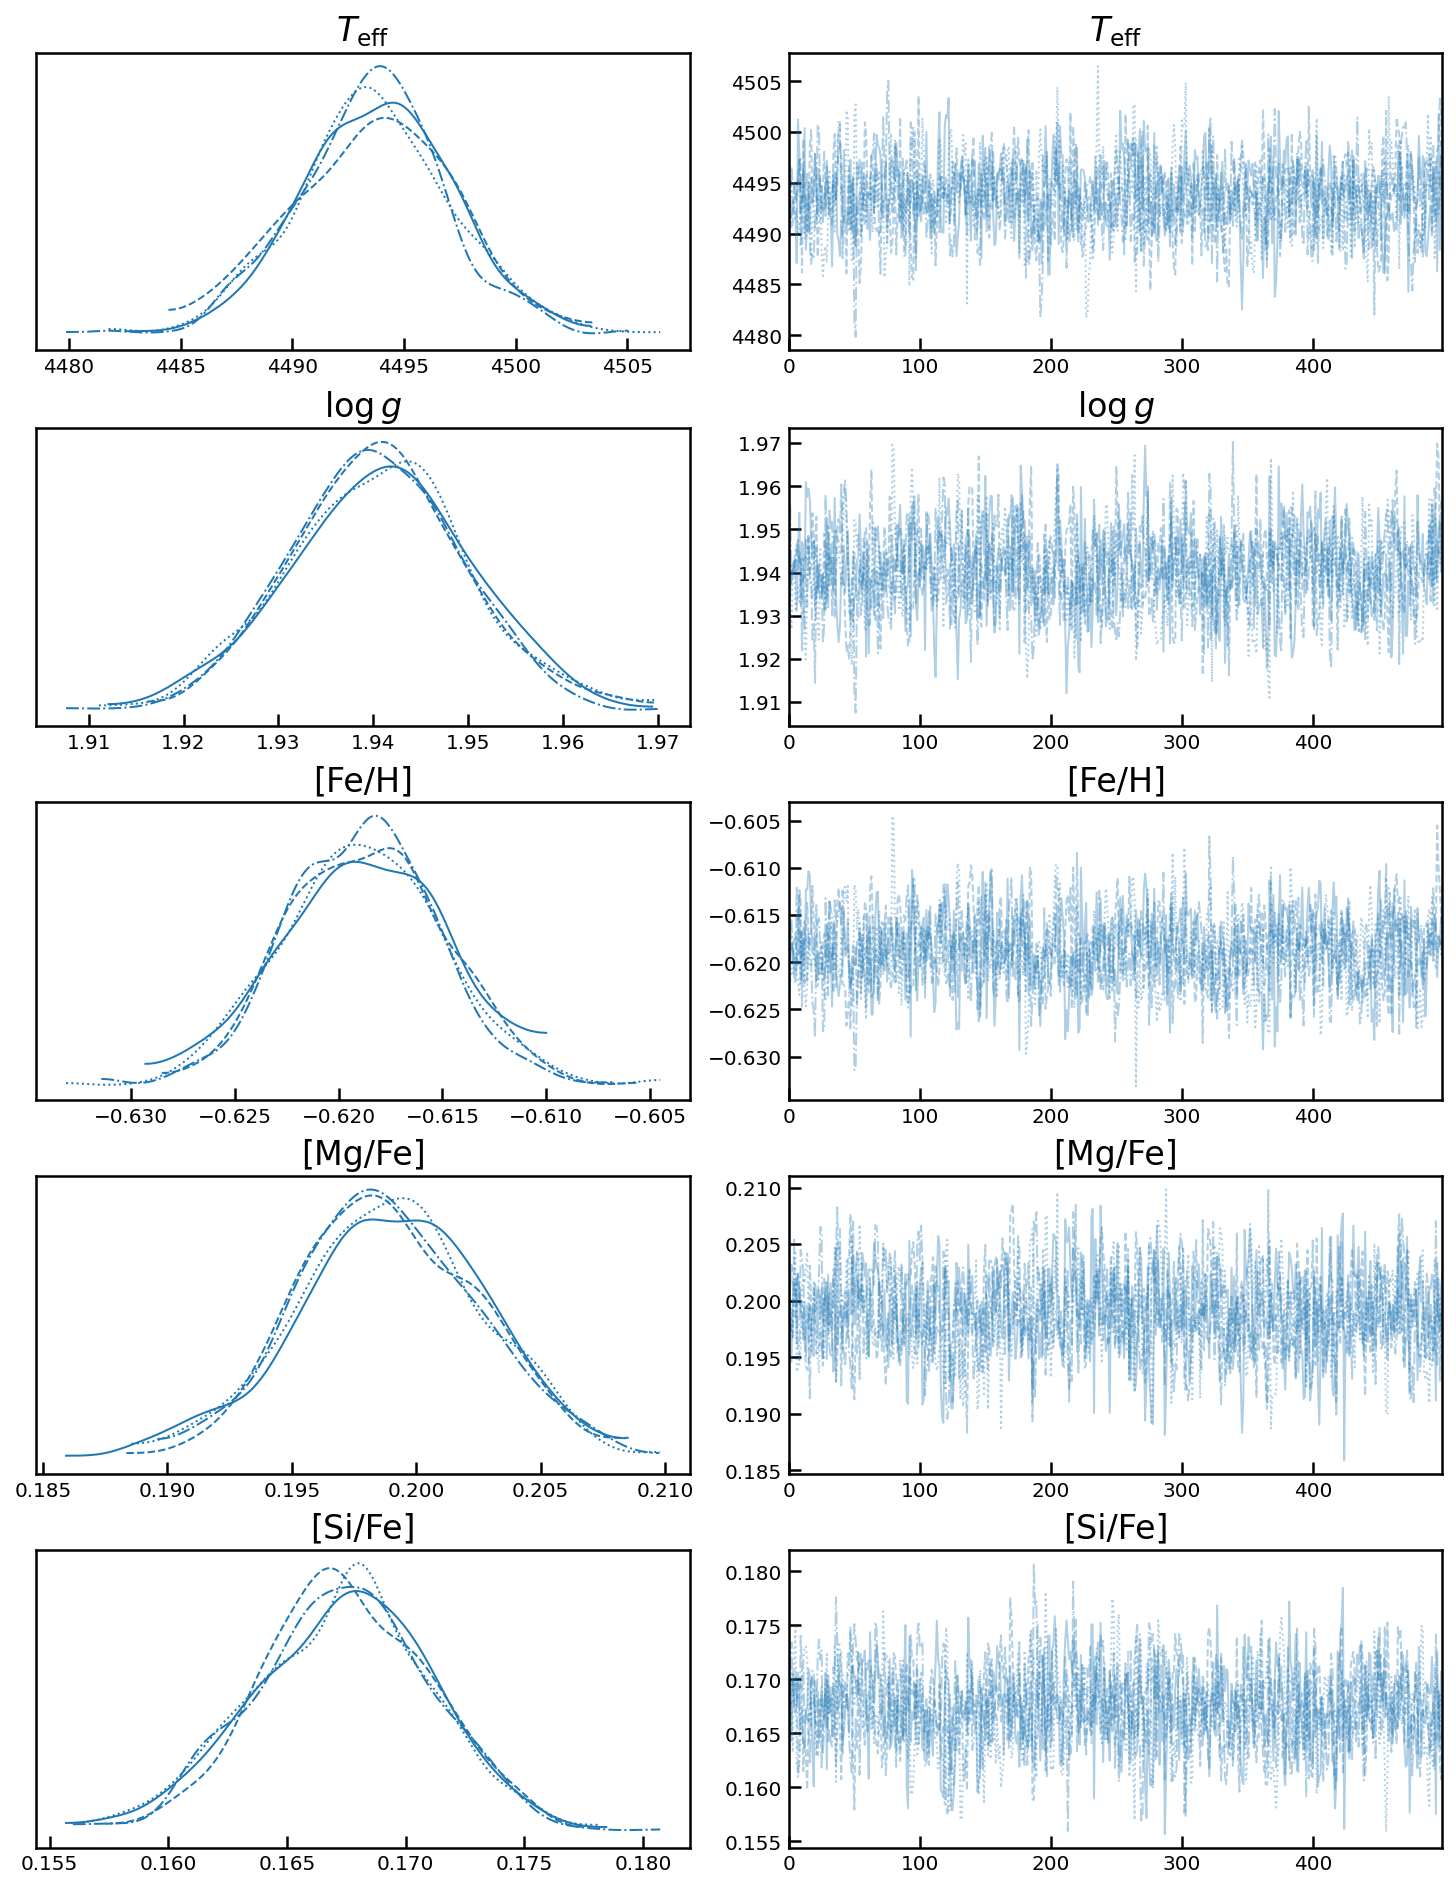

/Users/hiennguyen/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  \
$T_{\rm eff}$  4493.640  3.552  4486.888  4500.281       0.11    0.078   
$\log g$          1.941  0.009     1.923     1.958       0.00    0.000   
[Fe/H]           -0.619  0.004    -0.626    -0.612       0.00    0.000   
[Mg/Fe]           0.199  0.004     0.192     0.206       0.00    0.000   
[Si/Fe]           0.167  0.004     0.160     0.174       0.00    0.000   

               ess_bulk  ess_tail  r_hat  
$T_{\rm eff}$    1053.0    1150.0    1.0  
$\log g$          939.0    1164.0    1.0  
[Fe/H]            930.0    1160.0    1.0  
[Mg/Fe]          1059.0     961.0    1.0  
[Si/Fe]          1062.0    1199.0    1.0

In [562]:
label_names = [r'$T_{\rm eff}$', r'$\log g$', '[Fe/H]', '[Mg/Fe]', '[Si/Fe]']

_ = pm.traceplot(_trace, var_names=label_names, figsize=(10,13))
# plt.tight_layout()
# plt.savefig(
#     figures_dir + 'results_mystery_spec_traceplot.pdf',
#     format='pdf'
# )
plt.show()
pm.summary(_trace, var_names=label_names)

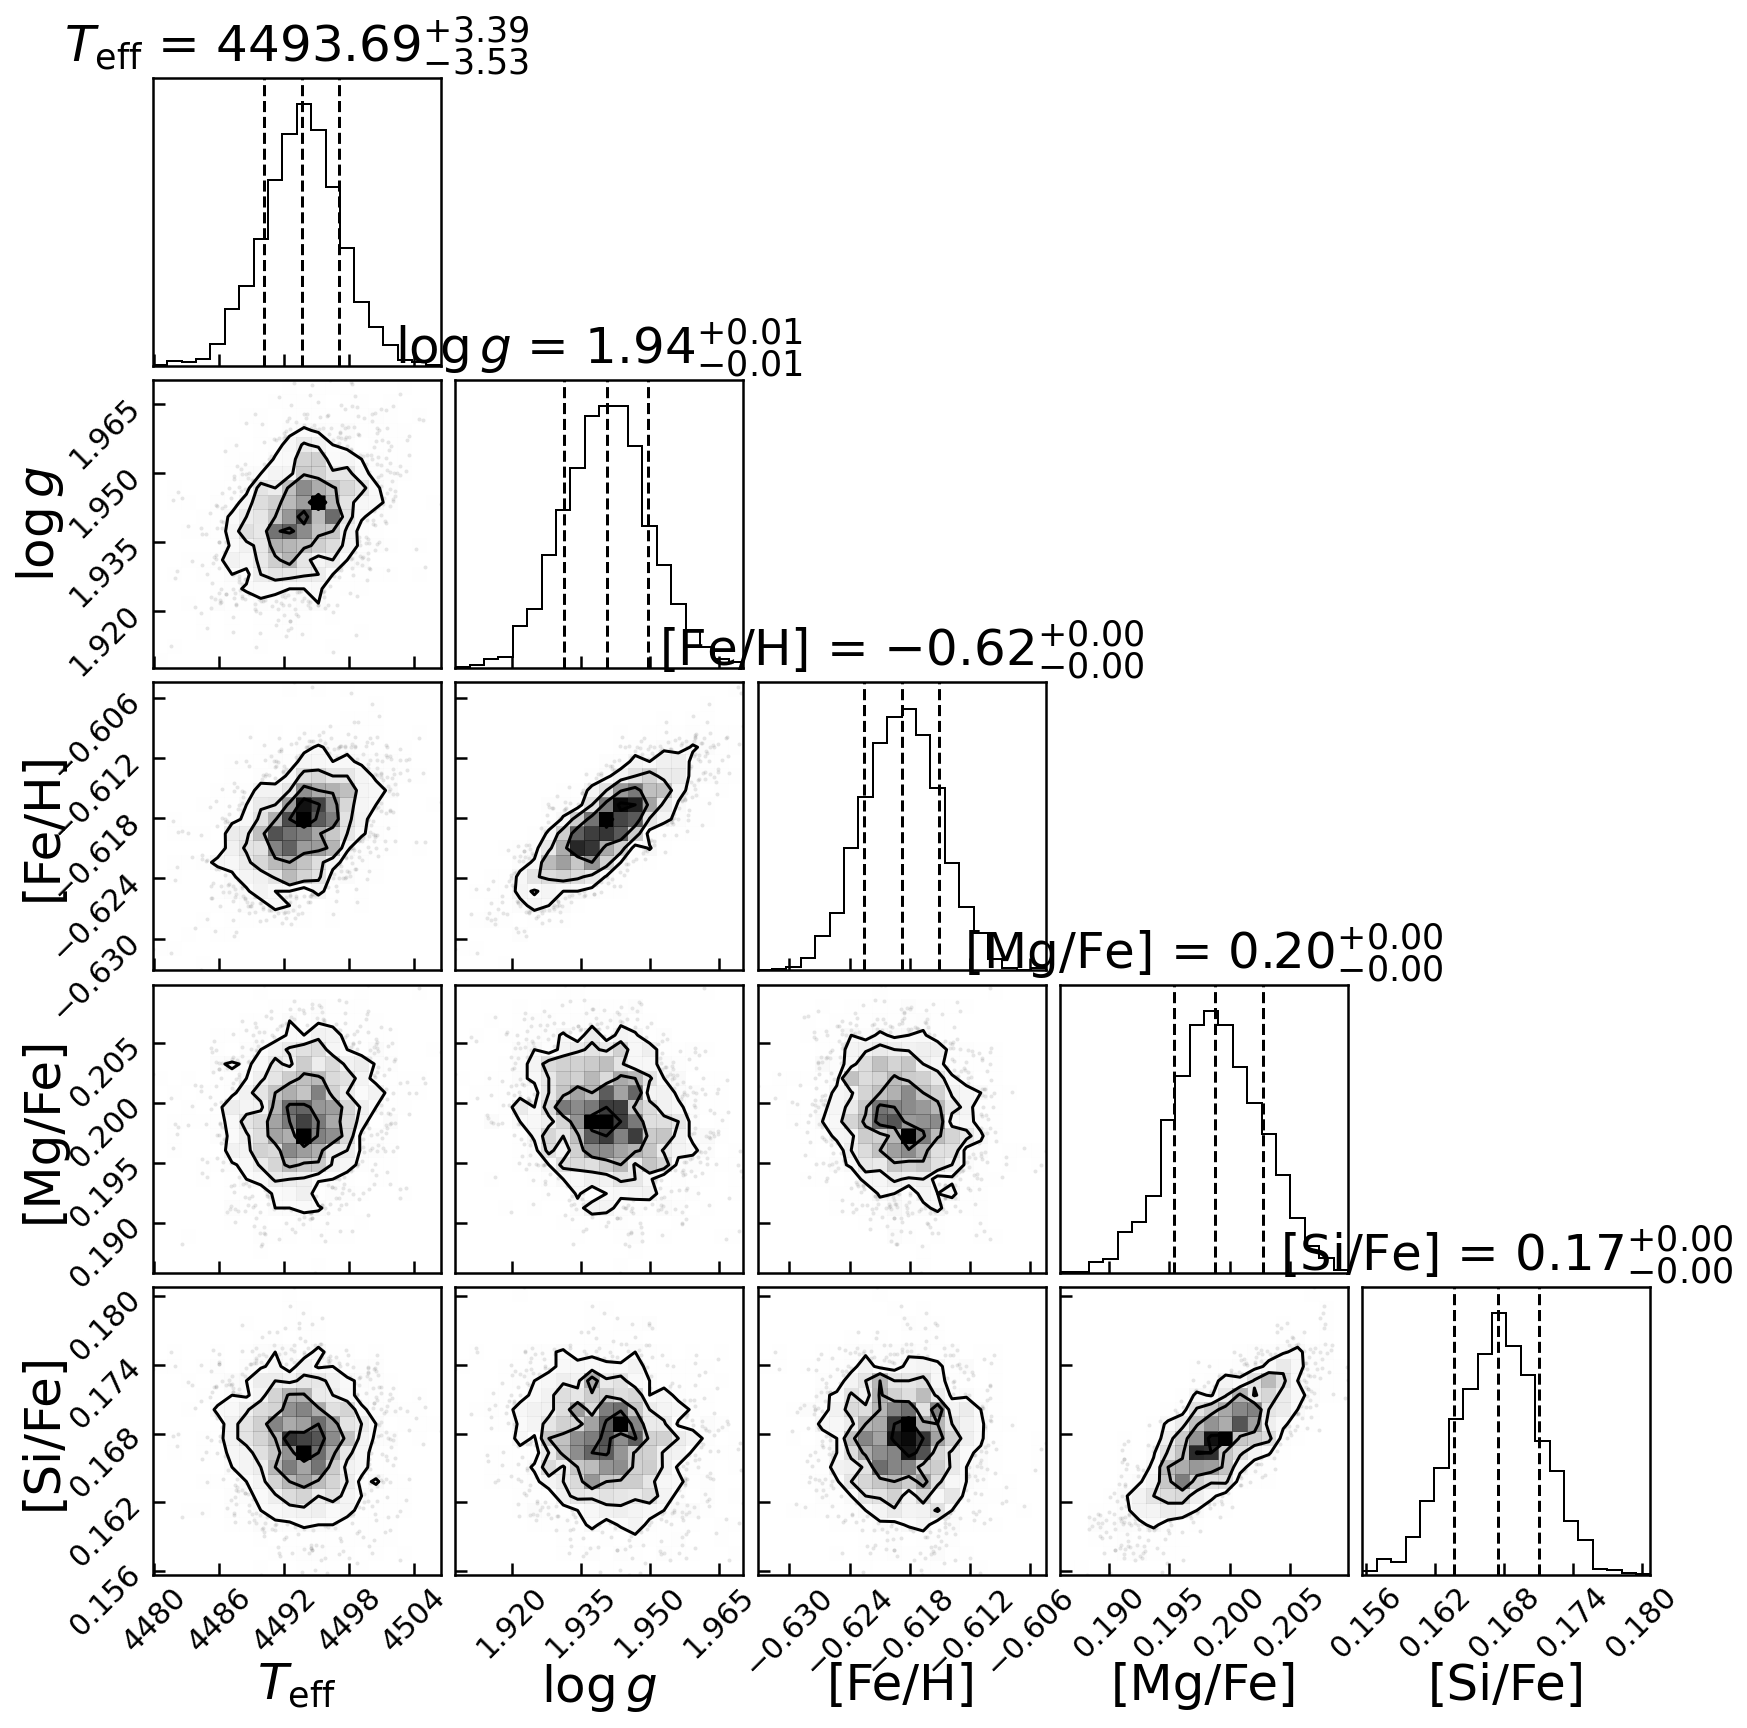

In [564]:
samples = pm.trace_to_dataframe(_trace, varnames=label_names)
_ = corner.corner(samples, quantiles=[.16, .5, .84], show_titles=True)
# plt.savefig(
#     figures_dir + 'results_mystery_spec_corner.pdf',
#     format='pdf',
# )

# 13.

***Use your model to make a plot using color and offset spectra that shows how the spectrum changes with metallicity at fixed Teff and logg. For clarity, show only the region of the spectrum from 16000 to 16200 Angstroms. Vary \[Fe/H\] from -1 to 0.5 and fix the atmospheric parameters to reasonable values.***

In [253]:
def model_spectrum_13(Teff, logg, FeH, MgFe, SiFe):
    
    # label vector
    row = [
        1, Teff, logg, FeH, MgFe, SiFe,
        Teff**2, Teff*logg, Teff*FeH, Teff*MgFe, Teff*SiFe,
        logg**2, logg*FeH, logg*MgFe, logg*SiFe,
        FeH**2, FeH*MgFe, FeH*SiFe,
        MgFe**2, MgFe*SiFe, 
        SiFe**2
    ]
    
    spectrum_model_list = []

    for wavelength_bin in range(len(thetas_matrix)):
        flux_model_value = np.matmul(row, thetas_matrix[wavelength_bin])
        spectrum_model_list.append(flux_model_value)
    
    spectrum_model = np.array(spectrum_model_list)
    
    return spectrum_model

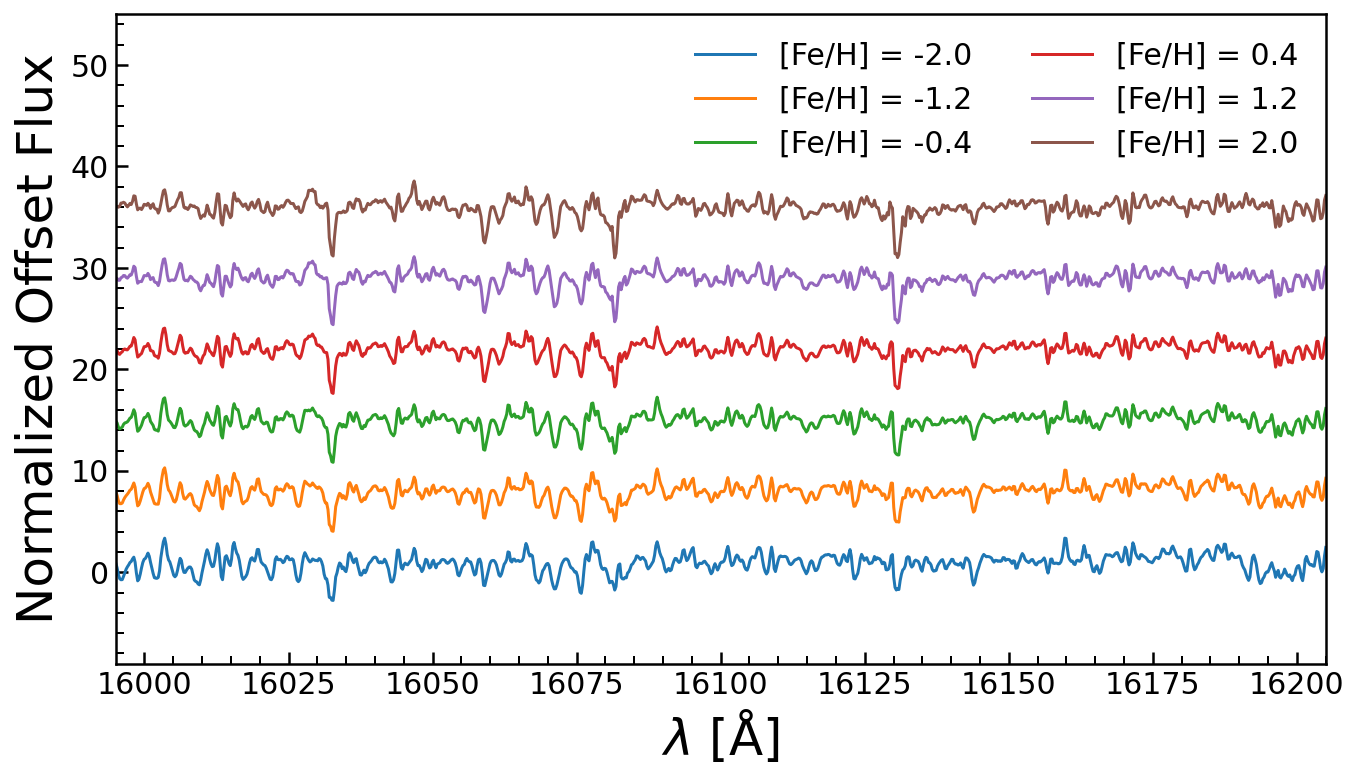

In [462]:
FeH_var = np.linspace(-2, 2, 6)

plt.figure(figsize=(10,6))

offset = 0

for FeH_value in FeH_var:
    spectrum_model = model_spectrum_13(
        Teff_mean,
        logg_mean,
        FeH_value,
        MgFe_mean,
        SiFe_mean
    )
    plt.plot(
        wavelengths_list_train[0],
        spectrum_model + offset,
        label=f'[Fe/H] = {np.round(FeH_value, 1)}'
    )
    
    offset += 7

plt.xlim(15995, 16205)
plt.ylim(-9,55)
plt.xlabel(r'$\lambda$ $\left[\rm \AA\right]$')
plt.ylabel('Normalized Offset Flux')
# plt.title('Offset Spectra Varying Metallicity')
plt.minorticks_on()
plt.legend(frameon=False, ncol=2)
plt.tight_layout()
# plt.savefig(
#     figures_dir + 'results_offset_spec_vary_z.pdf',
#     format='pdf'
# )
plt.show()

# 14.

***Make a plot using color and offset spectra to show how the same region of the spectrum changes as a star ascends the red giant branch. Fix $\left[\rm Fe/H\right] = 0$, and vary $\log \rm g$ from $3.5$ to $0.5$, simultaneously varying $\rm T_{eff}$ such that the star moves along an isochrone.***

***Comment on the similarities and differences of how the spectrum changes when the composition changes vs. when the star moves up the RGB at fixed composition. How can one tell the differences between a cool, low-$\log \rm g$ star and a warmer, higher-$\log \rm g$ star that is more metal-rich?***

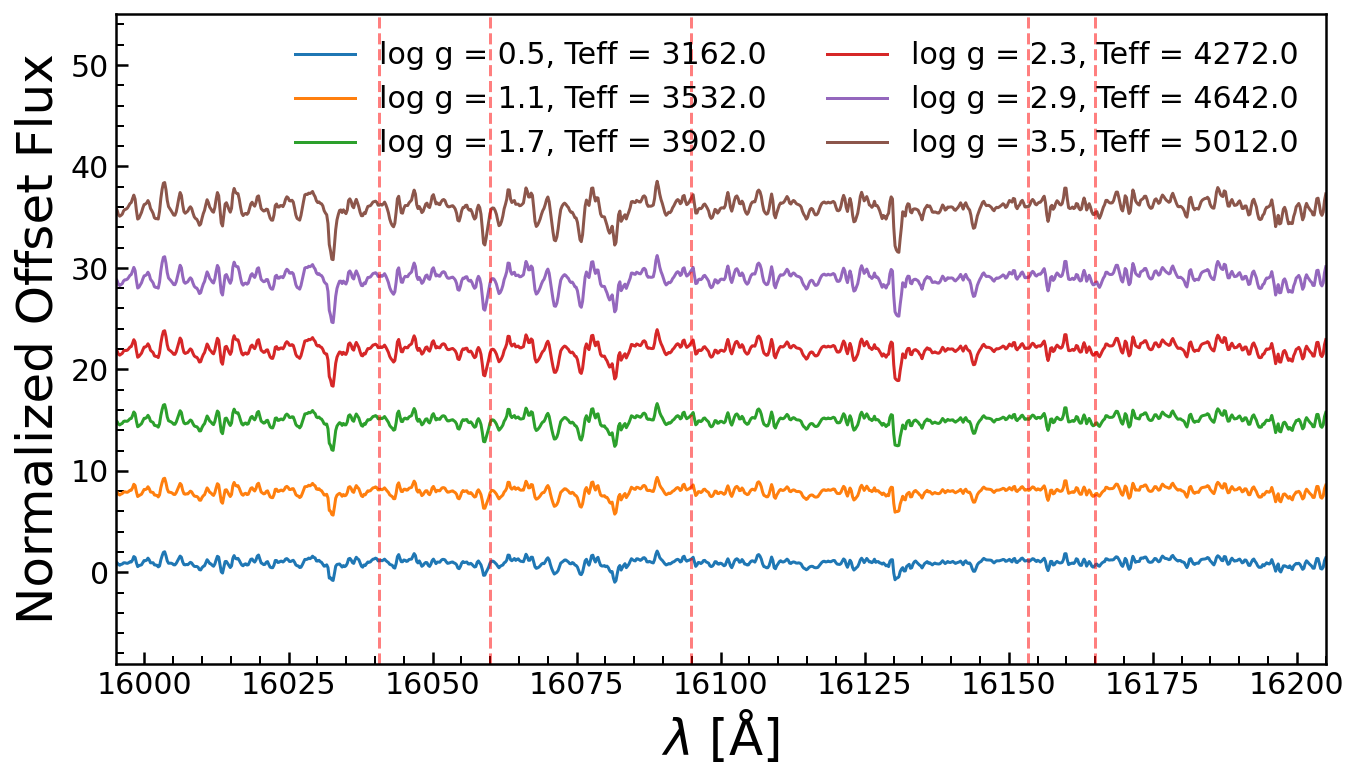

In [466]:
logg_var = np.linspace(0.5, 3.5, 6)
# from kiel diagram
teff_var = np.linspace(10**(3.5), 10**(3.7), 6)

offset = 0

offset = 0

plt.figure(figsize=(10,6))
for i in range(len(logg_var)):
    spectrum_model = model_spectrum_13(
        teff_var[i],
        logg_var[i],
        0, 0, 0
    )
    plt.plot(
        wavelengths_list_train[0],
        spectrum_model + offset,
        label=f'log g = {np.round(logg_var[i], 1)}, Teff = {np.round(teff_var[i],0)}'
    )
    
    offset += 7

# for lines in absorption_lines.values():
#     for line in lines:
#         plt.axvline(x=line, c='r', linestyle='--', alpha=0.5)
        
plt.xlim(15995, 16205)
plt.ylim(-9,55)
plt.xlabel(r'$\lambda$ $\left[\rm \AA\right]$')
plt.ylabel('Normalized Offset Flux')
# plt.title('Offset Spectra Varying Surface Gravity\nand Effective Temperature')
plt.minorticks_on()
plt.legend(frameon=False, ncol=2)
plt.tight_layout()
# plt.savefig(
#     figures_dir + 'results_offset_spec_vary_logg_teff.pdf',
#     format='pdf'
# )
plt.show()

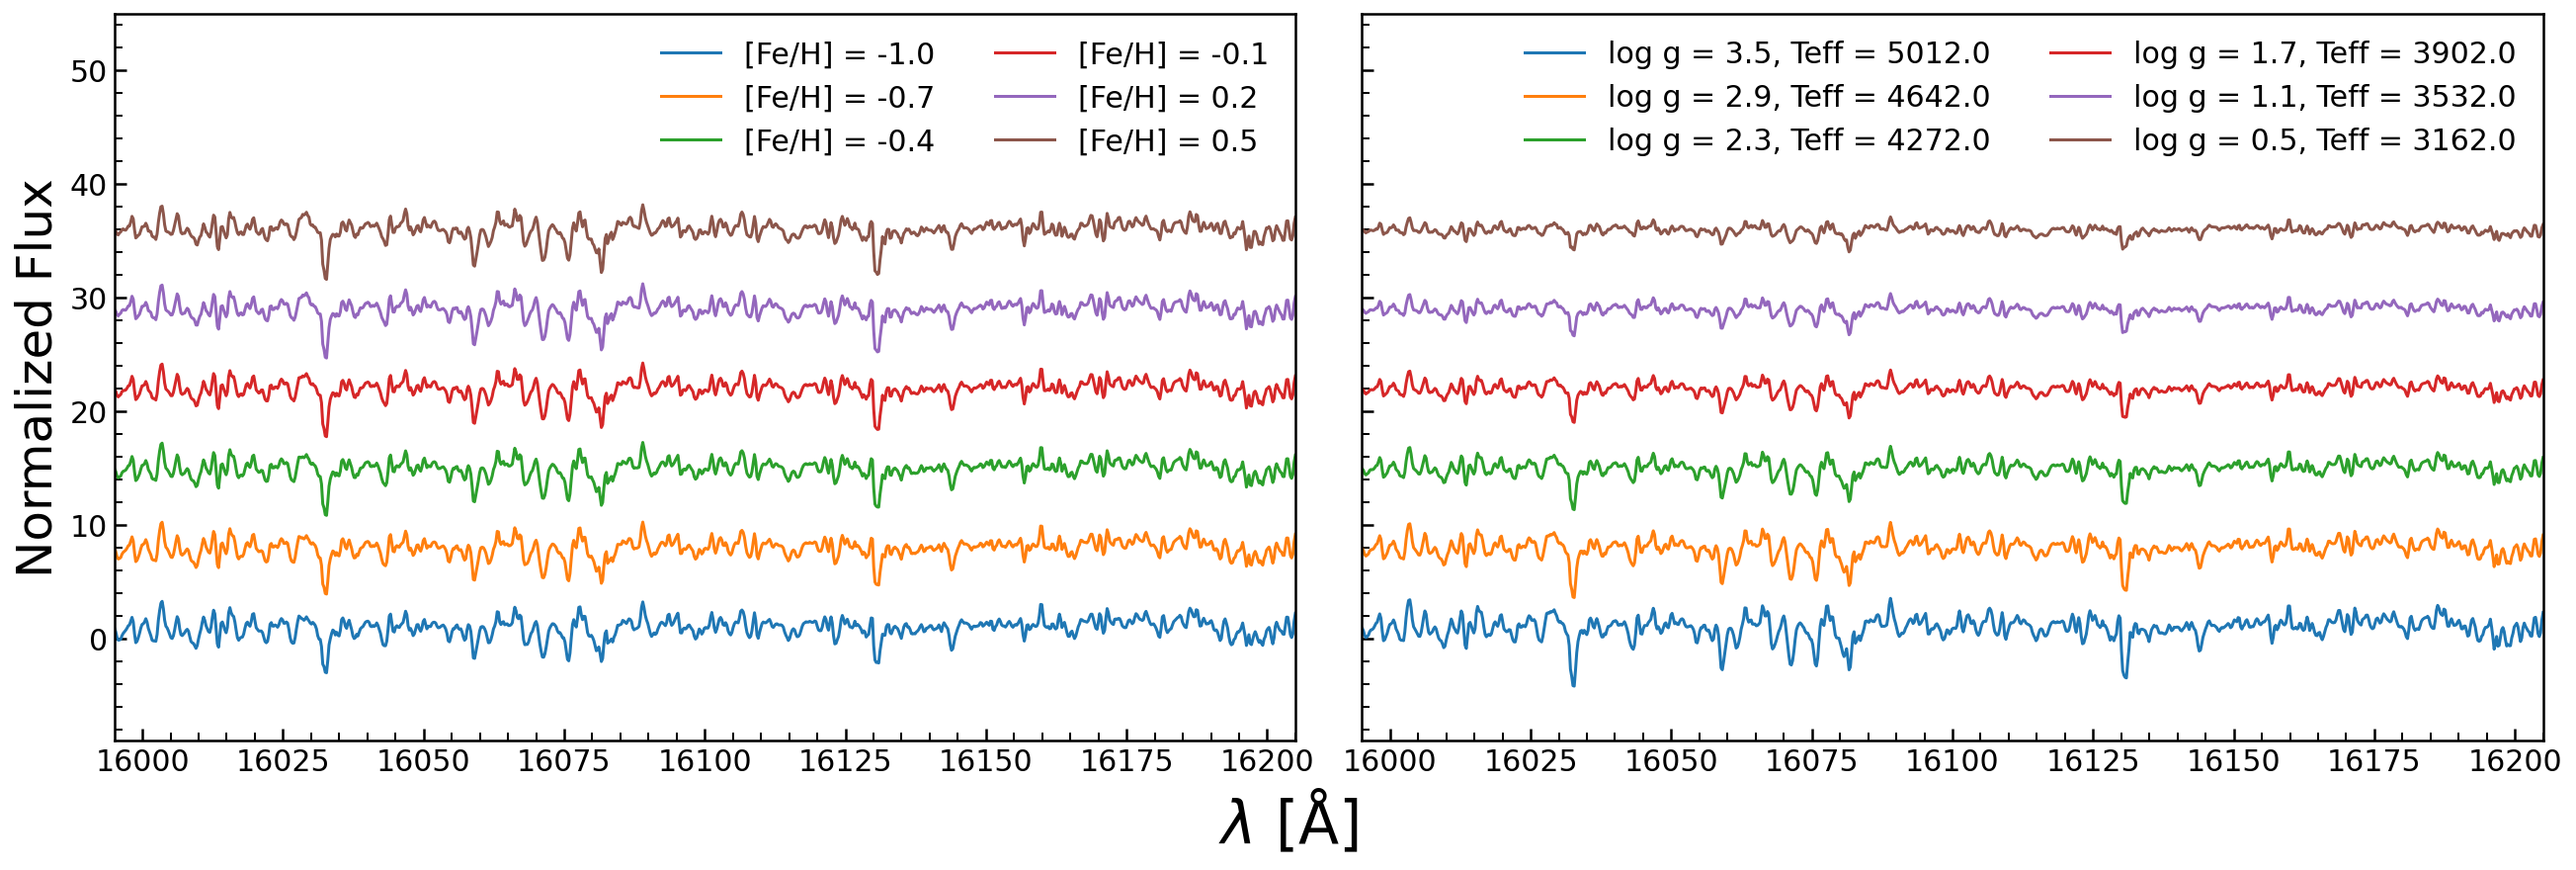

In [568]:
# Create a figure with a 1x2 subplot layout
fig, axs = plt.subplots(1, 2, figsize=(18, 6), sharey=True, layout='constrained')
fig.supxlabel(r'$\lambda$ $\left[\rm \AA\right]$')

# Plot for FeH variation
FeH_var = np.linspace(-1, 0.5, 6)

offset = 0

for FeH_value in FeH_var:
    spectrum_model = model_spectrum_13(
        Teff_mean,
        logg_mean,
        FeH_value,
        MgFe_mean,
        SiFe_mean
    )
    axs[0].plot(
        wavelengths_list_train[0],
        spectrum_model + offset,
        label=f'[Fe/H] = {np.round(FeH_value, 1)}'
    )
    
    offset += 7

axs[0].set_xlim(15995, 16205)
axs[0].set_ylim(-9, 55)
# axs[0].set_xlabel(r'$\lambda$ $\left[\rm \AA\right]$')
axs[0].set_ylabel('Normalized Flux')
axs[0].minorticks_on()
axs[0].legend(frameon=False, ncol=2)
# axs[0].set_title('Offset Spectra Varying Metallicity')

# Plot for logg and Teff variation
logg_var = np.linspace(3.5, 0.5, 6)
teff_var = np.linspace(10**(3.7), 10**(3.5), 6)

offset = 0

for i in range(len(logg_var)):
    spectrum_model = model_spectrum_13(
        teff_var[i],
        logg_var[i],
        0, 0, 0
    )
    axs[1].plot(
        wavelengths_list_train[0],
        spectrum_model + offset,
        label=f'log g = {np.round(logg_var[i], 1)}, Teff = {np.round(teff_var[i],0)}'
    )
    
    offset += 7

axs[1].set_xlim(15995, 16205)
axs[1].set_ylim(-9, 55)
# axs[1].set_xlabel(r'$\lambda$ $\left[\rm \AA\right]$')
# axs[1].set_ylabel('Normalized Offset Flux')
axs[1].minorticks_on()
axs[1].legend(frameon=False, ncol=2)
# axs[1].set_title('Offset Spectra Varying Surface Gravity and Effective Temperature')

# plt.savefig(
#     figures_dir + 'results_offset_spec.pdf',
#     format='pdf'
# )

plt.show()